In [2]:
import pandas as pd
import SD_Project as SD
import numpy as np
import gsw
import seawater as sw
import xarray as xr
#import glidertools as gt
import datetime

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [38]:
# Sarahs suggestion .try to translate in python 
 #a=randn(100000,1);
#for i=1:100
#for j=1:i
#test(j)=mean(a(j:i:end));
#end
#plot(i,test,'.'); hold on
#c(i)=std(test);
#end
#plot(1:100,c,'LineWidth',2)

a = np.random.standard_normal(100000)
#plt.hist(a)


test=[]
testj=[]
c=[]
for i in np.arange(1, 100):
    for j in range(1,i):
        testj.append(np.mean(a[j::i]))
    test.append(testj)
    c.append(np.std(testj))

C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


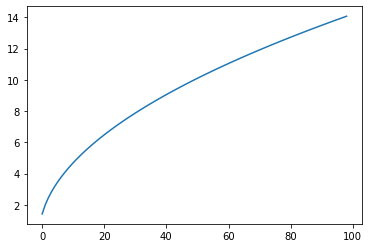

In [49]:
N=np.arange(1,100)
plt.plot(np.sqrt(2*N))

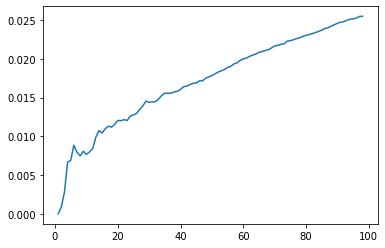

In [46]:
plt.plot(c)

# 1. Data cleaning and prep

# 1.1 Import data 

In [4]:
# import key variables from data sets 
#names_20=['latitude','longitude','BARO_PRES_MEAN','TEMP_AIR_MEAN','RH_MEAN','UWND_MEAN','VWND_MEAN','TEMP_CTD_MEAN','SAL_MEAN']
#names_22=['latitude','longitude','BARO_PRES_MEAN','TEMP_AIR_MEAN','RH_MEAN','UWND_MEAN','VWND_MEAN','TEMP_CTD_RBR_MEAN','SAL_RBR_MEAN']
#names_new=['latitude','longitude','pressure','airtemp','humidity','uwind','vwind','sst','salinity']


#filepath_20= 'C:/Users/Hanna/Python/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1564884498845.nc'
#DS_20= xr.open_dataset(filepath_20)
#DS_20= DS_20.rename(dict(zip(names_20,names_new)))[names_new].squeeze('trajectory')

#filepath_22= 'D:/Studium_der_Physik/M.Sc/Oceanography_Master/Masterthesis/SD_data/1022_new_merged.nc'
#DS_22= xr.open_dataset(filepath_22)
#DS_22= DS_22.rename(dict(zip(names_22,names_new)))[names_new]

#filepath_23= 'D:/Studium_der_Physik/M.Sc/Oceanography_Master/Masterthesis/SD_data/1023_new_merged.nc'
#DS_23= xr.open_dataset(filepath_23)
#DS_23= DS_23.rename(dict(zip(names_22,names_new)))[names_new]


In [3]:
# import key variables from data sets 
names_20=['latitude','longitude','BARO_PRES_MEAN','TEMP_AIR_MEAN','RH_MEAN','UWND_MEAN','VWND_MEAN','TEMP_CTD_MEAN','SAL_MEAN']
names_22=['latitude','longitude','BARO_PRES_MEAN','TEMP_AIR_MEAN','RH_MEAN','UWND_MEAN','VWND_MEAN','TEMP_CTD_RBR_MEAN','SAL_RBR_MEAN']
names_new=['latitude','longitude','pressure','airtemp','humidity','uwind','vwind','sst','salinity']


filepath_20= 'C:/Users/Hanna/Python/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1564884498845.nc'
DS_20= xr.open_dataset(filepath_20)
DS_20= DS_20.rename(dict(zip(names_20,names_new)))[names_new].squeeze('trajectory')

filepath_22= 'D:/Studium_der_Physik/M.Sc/Oceanography_Master/Masterthesis/SD_data/1022_new_merged.nc'
DS_22= xr.open_dataset(filepath_22)
DS_22= DS_22.rename(dict(zip(names_22,names_new)))[names_new]

filepath_23= 'D:/Studium_der_Physik/M.Sc/Oceanography_Master/Masterthesis/SD_data/1023_new_merged.nc'
DS_23= xr.open_dataset(filepath_23)
DS_23= DS_23.rename(dict(zip(names_22,names_new)))[names_new]


In [4]:
# make time a coordinate and drop trajectory(except for 1020, there it is droped later) in each dataset
t_20 = DS_20['time'].values
df_20 = DS_20.to_dataframe()
df_20.index = t_20
df_20.index.names=['time']
df_20 = df_20.drop(columns=['time'])

df_22 = DS_22.to_dataframe().drop(columns=['trajectory'])
df_23 = DS_23.to_dataframe().drop(columns=['trajectory'])

In [5]:
def make_cont_timevector(df_index):
    '''df_index: dataframe index [datetime64[ns]], df.index 
    output: contious timevector with same start and end date as dataframe '''
    import numpy as np
    td_full= (df_index[-1]- df_index[0])
    t_min= td_full.days*24*60
    td_rest= (df_index[-1]-np.timedelta64(td_full.days,'D'))-df_index[0]
    t_min= t_min + td_rest.seconds//60
    
    date = np.array(df_index[0], dtype=np.datetime64)
    vec= date + pd.to_timedelta(np.arange(t_min+1), 'm')
    return vec

In [6]:
# make contious time vectors for all three datasets, reproject onto this vector, fill up with nans 
df_cont={}
df= {'1020':df_20, '1022':df_22, '1023':df_23}
for frame in df:
    t_new= make_cont_timevector(df[frame].index)
    df_new= pd.DataFrame(index=t_new)
    df_new.index.names=['time']
    for var in df[frame].columns: 
        df_new[var] = pd.Series(df[frame][var], index=df[frame].index)
    df[frame]=df_new

# drop trajectory column for 1020  
df['1020'] = df['1020'].drop(columns=['trajectory'])

## 1.2 Calculate variables and mask missing ones

In [7]:
# calculate wind_10m, sensible and latent heat, despike salinity using SD package and 5min rolling mean
for d in df:
    df[d]['wind'] = SD.wind_to_ref_height(SD.wind(df[d]['uwind'],df[d]['vwind']), 3.6, 10) # correct wind speed to ref hight of 10m
    df[d]['wind'] = df[d]['wind'].rolling(5, center=True).mean()
    df[d]['airtemp'] =  df[d]['airtemp'].rolling(5, center=True).mean()
    df[d]['sst'] =  df[d]['sst'].rolling(5, center=True).mean()
    df[d]['humidity'] = df[d]['humidity'].rolling(5, center=True).mean()
    df[d]['salinity'] = df[d]['salinity'].rolling(5, center=True).mean()
    df[d]['humidity'] = df[d]['humidity'].rolling(5, center=True).mean()
    df[d]['pressure'] = df[d]['pressure'].rolling(5, center=True).mean()
    
    df[d]['Q_sens'] = SD.Q_sensible(df[d]['wind'], df[d]['airtemp'], df[d]['sst'])
    df[d]['Q_lat'] = -SD.Q_latent(df[d]['wind'], SD.humidity_spec_sat3(df[d]['humidity'], df[d]['airtemp'], df[d]['pressure']), SD.humidity_specific3(df[d]['humidity'], df[d]['airtemp'], df[d]['pressure']))
    df[d]['salinity']= SD.despike_sal(df[d]['salinity'], 0.1) # remove sal spikes: this takes lonnnng

In [8]:
# mask the complete row if one sensore is nan 
for d in df: 
    mask= np.ones(df[d].shape[0])
    for i in df[d].columns:
        mask= np.zeros(df[d].shape[0])*df[d][i]+mask

    for i in df[d].columns:
        df[d][i]=df[d][i]*mask

In [9]:
# calculate the distance and desnity 
for d in df:
    df[d]['sensor_p']=np.zeros(df[d]['wind'].shape[0]) # 
    df[d]['sensor_p'][:]=0.5 #sensor depth
    df[d]['density']= gsw.rho(gsw.SA_from_SP(df[d]['salinity'],  df[d]['sensor_p'], df[d]['longitude'], df[d]['latitude']), gsw.CT_from_t(df[d]['salinity'], df[d]['sst'],  df[d]['sensor_p']),  df[d]['sensor_p'])
    #df[d]['dist_covered']= np.zeros(len(df[d]['latitude']))
    df[d]['dist_cov'] = pd.Series(sw.dist(df[d]['latitude'], df[d]['longitude'], units='km')[0],index=df[d].index[1:])
    df[d]['dist_cov'] = df[d]['dist_cov'].replace(0.0, np.nan)
    df[d]['dist_NZ'] = df[d]['dist_cov'].cumsum() 
    df[d]['dist_cov'] = df[d]['dist_cov'].where(df[d]['dist_cov']>0.015)
    df[d]['sensor_p']=np.zeros((df[d]['wind'].shape[0]))# 
    df[d]['sensor_p'][:]=0.5 #sensor depth
    df[d]['alpha'] = gsw.alpha(gsw.SA_from_SP(df[d]['salinity'], df[d]['sensor_p'], df[d]['longitude'], df[d]['latitude']), gsw.CT_from_t(df[d]['salinity'], df[d]['sst'], df[d]['sensor_p']), df[d]['sensor_p'])
    df[d]['beta']= gsw.beta(gsw.SA_from_SP(df[d]['salinity'], df[d]['sensor_p'], df[d]['longitude'], df[d]['latitude']), gsw.CT_from_t(df[d]['salinity'], df[d]['sst'], df[d]['sensor_p']), df[d]['sensor_p'])

    R=np.abs((df[d]['alpha'][:-1]*np.diff(df[d]['sst']))/(df[d]['beta'][:-1]*np.diff(df[d]['salinity'])))
    df[d]['R'] = pd.Series(R, index=df[d].index[1:])
    
    df[d]['density_grad'] = (np.abs(np.diff(df[d]['density'])))/(df[d]['dist_cov'][1:])


In [11]:
df['1020']

,latitude,longitude,pressure,airtemp,humidity,uwind,vwind,sst,salinity,wind,Q_sens,Q_lat,sensor_p,density,dist_cov,dist_NZ,alpha,beta,R,density_grad
time,,,,,,,,,,,,,,,,,,,,
2019-01-19 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-19 04:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-19 04:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-19 04:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-19 04:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-03 04:26:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-03 04:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-03 04:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df['1020'].columns

Index(['latitude', 'longitude', 'pressure', 'airtemp', 'humidity', 'uwind',
       'vwind', 'sst', 'salinity', 'wind', 'Q_sens', 'Q_lat', 'sensor_p',
       'density', 'dist_cov', 'dist_NZ', 'alpha', 'beta', 'R', 'density_grad'],
      dtype='object')

In [15]:
pd.read_csv("df1020.csv")

,time,latitude,longitude,pressure,airtemp,humidity,uwind,vwind,sst,salinity,...,Q_sens,Q_lat,sensor_p,density,dist_cov,dist_NZ,alpha,beta,R,density_grad
0,2019-01-19 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-19 04:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-19 04:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-19 04:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-19 04:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282266,2019-08-03 04:26:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282267,2019-08-03 04:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282268,2019-08-03 04:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282269,2019-08-03 04:29:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#### have a section here where I show a case study of the data: 
k= np.mean(df['1023']['alpha'])/np.mean(df['1023']['beta'])
k*6

1.0966129280202246

In [17]:
#### Duration: usable data
#:]
print((df['1023'].index[-1]-df['1023'].index[0])+(df['1022'].index[-1]-df['1022'].index[0])+(df['1020'].index[95630]-df['1020'].index[29510]))

287 days 21:55:00


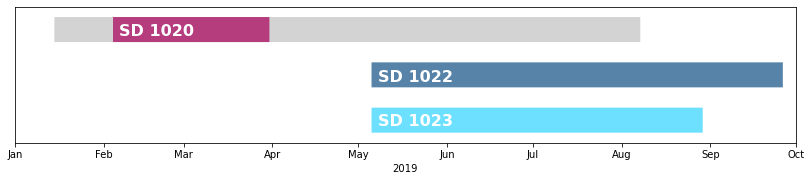

In [11]:
from matplotlib import dates

fig, (ax1) = plt.subplots(1,1,figsize =[14,2.5], sharex = True)
pick_time2= datetime.datetime(2019, 3, 26, 13,51,0)
t = np.where(df['1020'].index == pick_time2)

col=['lightgray', "#5783a8", "#6ee0ff"] #col=['#b53c7d',"#6ee0ff","#5783a8"]
c= '#b53c7d'
nr= [2, 1.8, 1.6]
i=0
for d in df:
    k= np.zeros(len(df[d].index))
    k[:]= nr[i]
    ax1.plot(df[d].index, k, color= col[i],linewidth=25)
    i=i+1

l= np.zeros(len(df[d].index[29510:95630]))
l[:]= 2
#ax1.plot(df['1020'].index[:t[0][0]], l, color= 'c',linewidth=25)
ax1.plot(df['1020'].index[29510:95630], l, color= c,linewidth=25)

fmtr2= dates.DateFormatter("%b")
fig.gca().xaxis.set_major_formatter(fmtr2)
ax1.set_xlabel('2019')
ax1.set_ylim(1.5,2.1)
pick_time = datetime.datetime(2019, 1, 1, 0, 0, 0), datetime.datetime(2019, 10, 1, 0, 0, 0)
ax1.set_xlim(pick_time)


fig.text(0.228, 0.72, 'SD 1020', color= 'w', weight= 'bold', size= 16)
fig.text(0.485,  0.465, 'SD 1022', color= 'w', weight= 'bold', size= 16)
fig.text(0.485,0.22, 'SD 1023', color= 'w', weight= 'bold', size= 16)

ax1.axes.get_yaxis().set_visible(False)
#fig.savefig("EGU_deploymenttime_FINAL_short.pdf", bbox_inches='tight', transparent=True)

In [12]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 18}
t=0
d= '1023'
x= df[d]['dist_NZ'][t:] 
y1= df[d]['airtemp'][t:] 

y2= df[d]['humidity'][t:]
y3= df[d]['wind'][t:]

y4= df[d]['Q_sens'][t:]
y5= df[d]['density_grad'][t:]

y6= df[d]['sst'][t:]
y7= df[d]['salinity'][t:]

y8= df[d]['density'][t:]
y9= df[d]['density_grad'][t:]#np.abs(np.diff(df[d]['density']))
y10= df[d]['Q_lat'][t:]
y11= df[d]['density_grad'][t:]#np.abs(np.diff(df[d]['Q_lat']))

In [ ]:
#Figure for paper: Fig 2
a

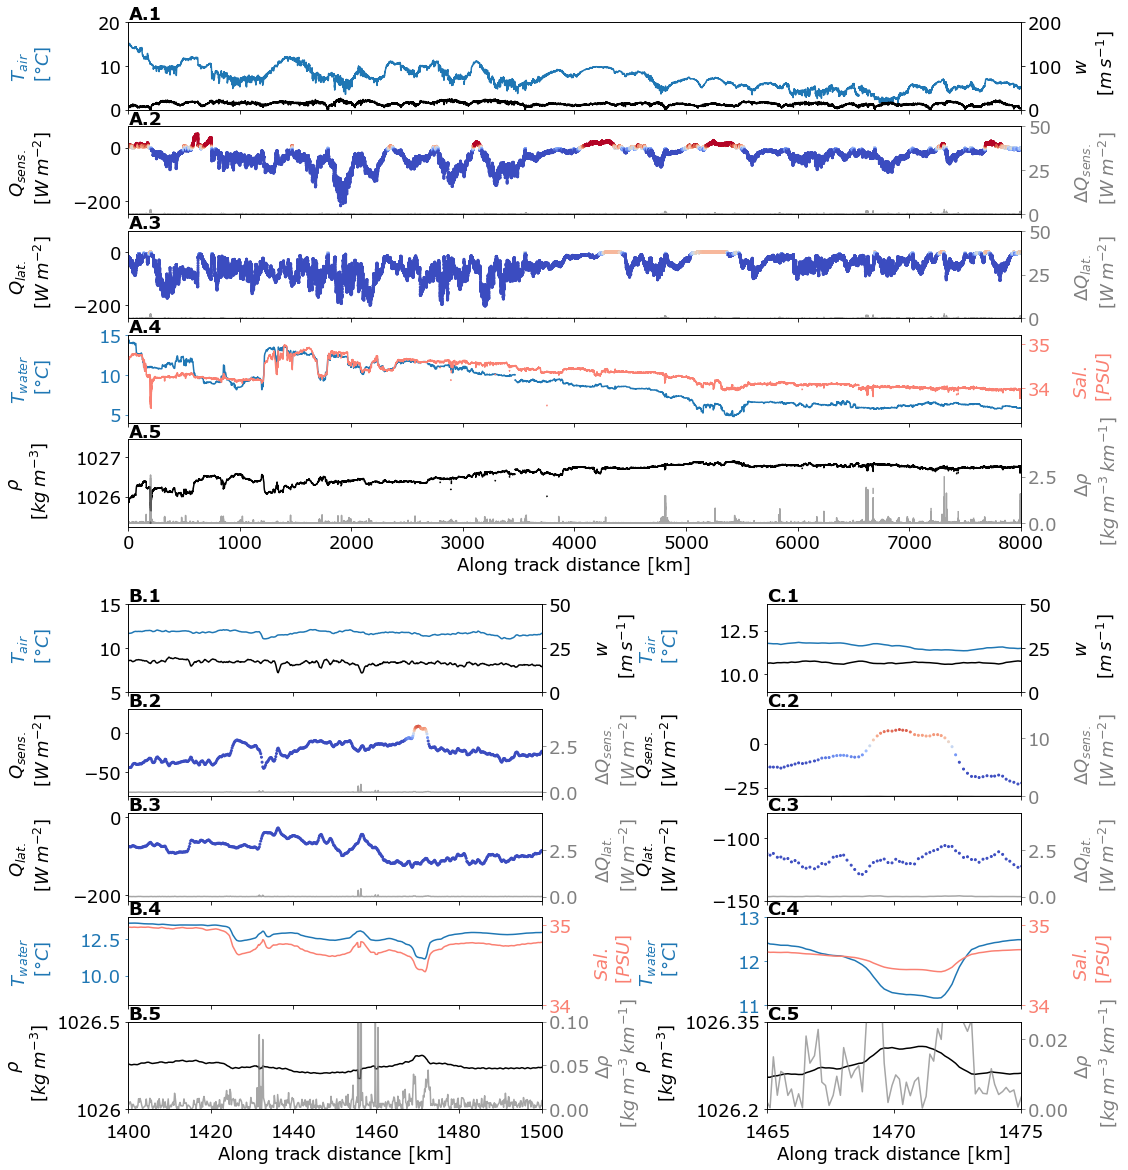

In [57]:
fig = plt.figure(figsize=[16, 20])

plt.rc('font', **font)

#heights = [1, 2]
width = [1, 1, 1, 1,1, 0.5, 1,1,1,1,1]
spec = fig.add_gridspec(ncols=6, nrows=11, height_ratios= width)


ax1 = fig.add_subplot(spec[0,:])
ax2 = fig.add_subplot(spec[1,:])
ax3 = fig.add_subplot(spec[2,:])
ax4 = fig.add_subplot(spec[3,:])
ax5= fig.add_subplot(spec[4,:])

ax6 = fig.add_subplot(spec[6,:3])
ax7 = fig.add_subplot(spec[7,:3])
ax8 = fig.add_subplot(spec[8,:3])
ax9 = fig.add_subplot(spec[9,:3])
ax10 = fig.add_subplot(spec[10,:3])

ax11 = fig.add_subplot(spec[6,4:])
ax12 = fig.add_subplot(spec[7,4:])
ax13 = fig.add_subplot(spec[8,4:])
ax14 = fig.add_subplot(spec[9,4:])
ax15 = fig.add_subplot(spec[10,4:])

ax1a = ax1.twinx()
ax2a = ax2.twinx()
ax3a = ax3.twinx()
ax4a = ax4.twinx()
ax5a = ax5.twinx()
ax6a = ax6.twinx()
ax7a = ax7.twinx()
ax8a = ax8.twinx()
ax9a = ax9.twinx()
ax10a = ax10.twinx()
ax11a = ax11.twinx()
ax12a = ax12.twinx()
ax13a = ax13.twinx()
ax14a = ax14.twinx()
ax15a = ax15.twinx()

ys= [y1, y2, y3, y4, y5, y6, y7, y8, y9,y10, y11]
axesa=[ax1a, ax2a, ax3a, ax4a, ax5a, ax6a, ax7a, ax8a, ax9a, ax10a, ax11a, ax12a, ax13a, ax14a, ax15a]
axes= [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]
axes_without=[ax1, ax2, ax3, ax4, ax6, ax7, ax8, ax9, ax11, ax12, ax13, ax14]
axes_with=[ax5, ax10, ax15]


for a in axes_with: 
    a.set_xlabel('Along track distance [km]')
    
ax_atm= [ax1, ax6, ax11]    
ax_atma=[ax1a, ax6a, ax11a]

ax_Qs=[ax2, ax7, ax12]
ax_Qsa=[ax2a, ax7a, ax12a]

ax_Ql=[ax3, ax8, ax13]
ax_Qla=[ax3a, ax8a, ax13a]

ax_wt= [ax4,ax9,ax14]
ax_wta= [ax4a, ax9a, ax14a]

ax_d=[ax5, ax10, ax15]
ax_da=[ax5a, ax10a, ax15a]

zoom = False
if zoom:
    z=2
else:
    z=0
    
for a in ax_atm[z:]:
    a.plot(x, y1)
    a.set_ylim(0,20)
    a.set_ylabel('$T_{air}$ \n $[°C]$', color='C0')
    
for a in ax_atma[z:]:
    a.plot(x, y3, color= 'k')
    a.set_ylabel('$w$ \n $[m\:s^{-1}]$', color='k')
    
for a in ax_Qs[z:]: 
    a.scatter(x, y4, c=y4, cmap= 'coolwarm', s=4, vmin= -10, vmax=10, zorder= 10)
    a.set_ylabel('$Q_{sens.}$ \n $[W\:m^{-2}]$', color='k')
for a in ax_Qsa[z:]:
    a.plot(x[t:], y5, color= 'grey', alpha= 0.7)
    a.tick_params(axis='y', colors='grey')
    a.set_ylabel('$\Delta Q_{sens.}$ \n $[W\:m^{-2}]$', color='grey')
    
for a in ax_Ql[z:]: 
    a.scatter(x, y10, c=y10, cmap= 'coolwarm', s=4, vmin= -10, vmax=5, zorder= 10)
    a.set_ylabel('$Q_{lat.}$ \n $[W\:m^{-2}]$', color='k')
for a in ax_Qla[z:]:
    a.plot(x[t:], y11, color= 'grey', alpha= 0.7)
    a.tick_params(axis='y', colors='grey')
    a.set_ylabel('$\Delta Q_{lat.}$ \n $[W\:m^{-2}]$', color='grey')
       
for a in ax_wt[z:]: 
    a.plot(x, y6)
    a.tick_params(axis='y', colors='C0')
    a.set_ylabel('$T_{water}$ \n $[°C]$', color='C0')
for a in ax_wta[z:]:
    a.plot(x, y7, color= 'salmon')
    a.tick_params(axis='y', colors='salmon')
    a.set_ylabel('$Sal.$ \n $[PSU]$', color='salmon')
    
for a in ax_d[z:]: 
    a.plot(x, y8, color= 'k')
    a.set_ylabel('$\\rho $ \n $[kg\:m^{-3}]$', color='k')

for a in ax_da[z:]:
    a.plot(x[t:], y9, color= 'grey', alpha= 0.7)
    a.tick_params(axis='y', colors='grey')
    a.set_ylabel('$\Delta \\rho$ \n $[kg\:m^{-3}\:km^{-1}]$', color='grey')
    
for a in axes_without: 
    a.tick_params(axis='x', which='both',  bottom=True, top=False, labelbottom=False)

## choope zooms: 
ax_b1=[ax1, ax1a, ax2, ax2a, ax3, ax3a, ax4, ax4a, ax5, ax5a]
ax_b2=[ax6, ax7, ax8, ax9, ax10, ax6a, ax7a, ax8a, ax9a, ax10a]
ax_b3=[ax11, ax12, ax13, ax14, ax15, ax11a, ax12a, ax13a, ax14a, ax15a]

for a in ax_b1: 
    a.set_xlim(0, 8000)
    
for a in ax_b2:
    a.set_xlim(1400, 1500)
    
for a in ax_b3:
    a.set_xlim(1465, 1475)
    
### fine tune y limits for sst and sal: 
ax1a.set_ylim(0,200)
ax2.set_ylim(-250, 80)
ax2a.set_ylim(0,50)
ax3.set_ylim(-250, 80)
ax3a.set_ylim(0,50)
ax4.set_ylim(4, 15)
ax4a.set_ylim(33.2, 35.21) #alpha/beta*11 = limits for sal 


ax6.set_ylim(5, 15)
ax6a.set_ylim(0,50)
ax7.set_ylim(-80, 30)
ax9.set_ylim(8, 14) # sal = 0.37
ax9a.set_ylim(34, 35.1)
ax10.set_ylim(1026, 1026.5)

ax10.set_yticks([1026, 1026.5])
ax10.set_yticklabels([1026, 1026.5])
ax10a.set_ylim(0, 0.1)

ax11.set_ylim(9, 14)
ax11a.set_ylim(0, 50)


ax12.set_ylim(-30, 20)
ax12a.set_ylim(0, 15)

ax13.set_ylim(-150, -80)
ax14.set_ylim(11, 13)
ax14a.set_ylim(34, 35.1)
#ax11.set_ylim(1026.2, 1026.35)
#ax11.set_yticklabels([1026.2,1026.35])
ax15a.set_ylim(0, 0.025)

ax15.set_ylim(1026.2,1026.35)
ax15.set_yticks([1026.2,1026.35])
ax15.set_yticklabels([1026.2,1026.35])
ax15.set_xticks([1465,1470,1475])
ax15.tick_params(axis='x',pad=10)
ax10.tick_params(axis='x',pad=10)

lab=['A.1','A.2', 'A.3', 'A.4', 'A.5', 'B.1', 'B.2', 'B.3','B.4', 'B.5','C.1', 'C.2', 'C.3', 'C.4', 'C.5']
r = [15]
for i in range(15): 
    axes[i].annotate(lab[i],xy=[0.001, 1.03], weight='bold', xycoords='axes fraction', color='k')
    #axes[i].legend(loc='upper right', handlelength= 1, labelspacing= 0.3)
#fig.tight_layout(pad= .5)
fig.align_ylabels()
#ax10.set_xlim(1000, 2000)
plt.subplots_adjust(wspace=.7)

fig.savefig("Rosenthal_etal_2022_figs/SD1023_casestudy_largeA.png", bbox_inches='tight', transparent=True,dpi=300)

In [30]:
#### sTART and END of SD1020 data: 
#start:29510
#end:  95630

#####TIME START and END:
#START: '2019-02-08 15:50:00' df['1020'].index[29510]
#STOP: 2019-03-26 13:50:00    df['1020'].index[95630]
###Duration for SD1020: 
# datetime.datetime(2019, 3, 26, 13, 50) - datetime.datetime(2019, 2, 8, 15, 50)
# length: 6'437


####SD1022#####
# START: 2019-05-10 00:04:00 #4
## END: '2019-09-21 23:51:00'#194391
#Duration: 134 days 23 hrs 
#length:11'186km 
#------------cut this to fit 45 days 2hrs, means start 4, end=64924 #### 45/9

In [141]:
len(np.arange(29510,95630,1))

66120

In [18]:
Qturb_cut_20=[]
time_cut_20=[]
for i in np.arange(29510,95630,1): 
    Qturb_cut_20.append(df['1020'].Q_sens[i]+df['1020'].Q_lat[i])
    time_cut_20.append(df['1020'].index[i])
    
np.savetxt('Qturb_cut_20.txt', Qturb_cut_20)
#np.savetxt('time_cut_20.txt', time_cut_20)

In [19]:
Qturb_cut_22=[]
time_cut_22=[]
for i in np.arange(4,66124,1): 
    Qturb_cut_22.append(df['1022'].Q_sens[i]+df['1022'].Q_lat[i])
    time_cut_22.append(df['1022'].index[i])
    
np.savetxt('Qturb_cut_22.txt', Qturb_cut_22)
#np.savetxt('time_cut_22.txt', time_cut_22)


In [15]:
# Save Qturbulent data for 45days, 2hrs, with 1min resolution
len(Qturb_cut_22)

66120

In [61]:
len(Qturb_cut_20)

66120

In [12]:
### find locations every week: (in 45 days 6 positions)
# SD1022
# list of positions
pos_22=[]
pos_20=[]
time_pos22=[]
time_pos20=[]
for i in range(0,6): 
    t=df['1022'].index [4] + datetime.timedelta(days=i*7)
    time_pos22.append(t)
    pos_22.append((df['1022'].latitude[t], df['1022'].longitude[t]))
    t=df['1020'].index [29510] + datetime.timedelta(days=i*7)
    time_pos20.append(t)
    pos_20.append((df['1020'].latitude[t], df['1020'].longitude[t]))    
    
np.savetxt('pos_1020.txt', pos_20)
np.savetxt('pos_1022.txt', pos_22)



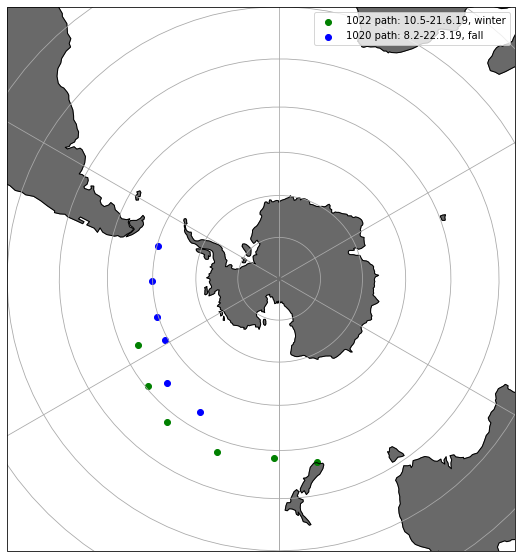

In [115]:
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import SD_Project as SD
import xarray as xr
import numpy as np
import gsw
import datetime
import seawater as sw
import cartopy
import cartopy.crs as ccrs
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import colorbar, colors
import matplotlib
import matplotlib.path as mpath


fig = plt.figure(figsize=[10,10])
ax = plt.axes(projection=ccrs.SouthPolarStereo())
gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None, color='darkgrey')
gl.n_steps = 90
ax.add_feature(cartopy.feature.LAND, color='dimgrey')
ax.coastlines()
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_extent([-180, 60, -90, -30], ccrs.PlateCarree())
#t = pd.dataframe(time_pos20)
c=[(0,0.1*i,0) for i in range(6)]
for i in range(6):
    plt.scatter(pos_20[i][1], pos_20[i][0], transform=ccrs.PlateCarree(),color='blue')
    plt.scatter(pos_22[i][1], pos_22[i][0], transform=ccrs.PlateCarree(), c='green')
plt.scatter([],[],transform=ccrs.PlateCarree(), c='green', label='1022 path: 10.5-21.6.19, winter')
plt.scatter([],[],transform=ccrs.PlateCarree(), c='blue', label='1020 path: 8.2-22.3.19, fall')
plt.legend()

#plt.savefig("MAP_subsampledtemporal_autocorrelation.png", bbox_inches='tight')#, transparent=True)

## REGRID DATA to be equidistant: 


In [15]:
df1023= df['1023'].to_xarray()
dist_1km = np.arange(0, np.nanmax(df['1023']['dist_NZ']), 1)#0.05
dist_NZ =df['1023']['dist_NZ']
df_equal= df1023.assign_coords(dist_NZ=("time", dist_NZ))
df_eq= df_equal.swap_dims({'time': 'dist_NZ'})
df_eq_nonann= df_eq.dropna(dim='dist_NZ')
interp_end= df_eq_nonann.interp(dist_NZ= dist_1km)


In [16]:
# regrid the data to equal distance (instead of equal time):
#distance_data= df['1023']['dist_NZ']
#data= df['1023']
#resolution_outout= 1
def regrid_SDdata(data, distance_data, resolution_output):
    '''
    data: SD data in dictonary , example: df['1023']
    distance_data: in dictornary , [km], example:  df['1023']['dist_NZ']
    resolution_output: [km]
    '''
    import numpy as np 
    import xarray as xr
    
    df1023= data.to_xarray()
    dist_1km = np.arange(0, np.nanmax(distance_data), resolution_output)
    dist_NZ =distance_data
    df_equal= df1023.assign_coords(dist_NZ=("time", dist_NZ))
    df_eq= df_equal.swap_dims({'time': 'dist_NZ'})

    df_eq_nonann= df_eq.dropna(dim='dist_NZ')
    
    interp_end= df_eq_nonann.interp(dist_NZ= dist_1km)
    return interp_end

#data= interp_end.Q_sens
#res= 1
#res_end= int(len(data)/2)
#res_start=0
def subsample(data, res, res_end):
    '''
    data: resgridded data, only Q
    res: resolution from the regridded data [km]
    res_end: maximum resampling frequency ( max len(data)/2)'''
    subs=[]#np.zeros(res_end)
    samp_res=[]
    subsampled_n= []
    for i in np.arange(2, res_end):
        
        
        for j in range(0, i): 
            subsampled_n.append(data[j::i][:int(len(data)/i)])
        #sampling_res.append(res*i)
        subs.append(np.nanmean(subsampled_n, axis=0))
        samp_res.append(res*i)
    return subs, samp_res, subsampled_n

def subsample_unique(data, res, res_end):
    '''
    data: resgridded data, only Q
    res: resolution from the regridded data [km]
    res_end: maximum resampling frequency ( max len(data)/2)'''
    subs=[]#np.zeros(res_end)
    samp_res=[]
    subsampled_n= []
    for i in np.arange(2, res_end):
        for j in range(0, i):
            subsampled_n.append(data[::i])
            
        mean.append(subsampled_n)
        #sampling_res.append(res*i)
       #subs.append(np.nanmean(subsampled_n, axis=0))
        #samp_res.append(res*i)
    return subsampled_n, mean, std

In [11]:
# cut data to fit Sd1020: chose 45 days 22hrs ( this is the length of data vavaiablity in Sd1020)
# start at 12th august, last day to have sst measuemnts for sd1023 and go backwards 45 days, 22hrs
#BACKWARDS !!!!!
#### cut everything form Sd1020 that is nan: 
b= np.where(np.isfinite(df['1020']['sst']))
start20= b[0][0]
stop20= b[0][-1]
new_cut_df_20= df['1020'][start20:stop20]

end= np.where(np.isfinite(df['1023']['sst']))[0][-1]
df['1023'].index[end]
new_cut_df_23=df['1023'][end-66120:end]
end_22= np.where(df['1022'].index == df['1023'].index[end])[0][0]
new_cut_df_22=df['1022'][end_22-66120:end_22]



### regrid this dataset 
regrid_Sd1020= regrid_SDdata(new_cut_df_20, new_cut_df_20['dist_NZ'], 1)
regrid_Sd1022= regrid_SDdata(new_cut_df_22, new_cut_df_22['dist_NZ'], 1)
regrid_Sd1023= regrid_SDdata(new_cut_df_23, new_cut_df_23['dist_NZ'], 1)

regrid_Qturb_1020= regrid_Sd1020.Q_sens +regrid_Sd1020.Q_lat
regrid_Qturb_1022= regrid_Sd1022.Q_sens +regrid_Sd1022.Q_lat
regrid_Qturb_1023= regrid_Sd1023.Q_sens +regrid_Sd1023.Q_lat

In [17]:
#### cut everything form Sd1020 that is nan: 
####FROM START 
b= np.where(np.isfinite(df['1020']['sst']))
start20= b[0][0]
stop20= b[0][-1]
new_cut_df_20= df['1020'][start20:stop20]

start= np.where(np.isfinite(df['1023']['sst']))[0][0]

new_cut_df_23=df['1023'][start: start+66120]
start_22= np.where(df['1022'].index == df['1023'].index[start])[0][0]
new_cut_df_22=df['1022'][start_22:start_22+66120]



### regrid this dataset 

regrid_Sd1020= regrid_SDdata(new_cut_df_20, new_cut_df_20['dist_NZ'], 1)
regrid_Sd1022= regrid_SDdata(new_cut_df_22, new_cut_df_22['dist_NZ'], 1)
regrid_Sd1023= regrid_SDdata(new_cut_df_23, new_cut_df_23['dist_NZ'], 1)


regrid_Qturb_1020= regrid_Sd1020.Q_sens +regrid_Sd1020.Q_lat
regrid_Qturb_1022= regrid_Sd1022.Q_sens +regrid_Sd1022.Q_lat
regrid_Qturb_1023= regrid_Sd1023.Q_sens +regrid_Sd1023.Q_lat

In [40]:
#np.nanmedian(df['1020']['dist_cov'])

0.0985260214681847

In [18]:
regrid_Qturb_1020.to_netcdf("paper_plots_new/detrend/ridded_Qturb_1020b.nc")
regrid_Qturb_1022.to_netcdf("paper_plots_new/detrend/ridded_Qturb_1022b.nc")
regrid_Qturb_1023.to_netcdf("paper_plots_new/detrend/ridded_Qturb_1023b.nc")

In [19]:
'''
Calculate the autocovarriance and autocorrelation coefficients.
'''

import numpy as np

def autocovariance(Xi, N, k, Xs):
    autoCov = 0
    for i in np.arange(0, N-k):
        autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
    return (1/(N-1))*autoCov

def autocorrelation():
    return autocovariance(Xi, N, k, Xs) / autocovariance(Xi, N, 0, Xs)


In [14]:
# Autocorreletion
Xi = regrid_Qturb_1020.values[1:]
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_k20=[]
autocovar_k20=[]
l= np.size(Xi)-1 
for i in np.arange(l):
    autocovar_k20.append(autocovariance(Xi, N, i, Xs))
    autocorr_k20.append(autocovariance(Xi, N, i, Xs)/ autocovariance(Xi, N, 0, Xs))

NameError: name 'autocorr_k22' is not defined

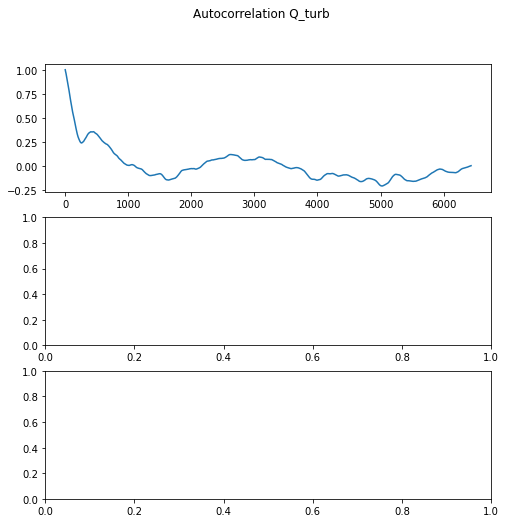

In [15]:
# compare the three plots 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
fig.suptitle('Autocorrelation Q_turb')
ax1.plot(autocorr_k20)
ax2.plot(autocorr_k22)
ax3.plot(autocorr_k23)
fig.subplots_adjust(hspace = 0.5)


ax3.set_xlabel('delay[km]')
ax1.set_ylabel('Correlation 20')
ax2.set_ylabel('Correlation 22')
ax3.set_ylabel('Correlation 23')

for a in [ax1, ax2, ax3]: 
    a.axhline(0,c='k')
#plt.savefig("Autocorrlation_Q_turb.png", bbox_inches='tight')#, transparent=True)

In [17]:
#THIS IS the FUNCTION USED IN PAPER FIG

def subsamling_means(data, max_res): 
    '''
    input:
    data:data to subsample in array 
    max_res: maximal subsampling frequency (steps of 1 so far)
    
    outut: 
    all_means: means of all subsampled data sets, in list of array, where diffrent means for a sampling frequency mean diffrent starting points 
    mean: mean of all means of the data set from the same sampling frequency
    std: std of the mean of means from same sampling frequency
    corresponding sampling freq: range(1, max_res)
    
    '''
    means=[]
    std=[]
    mean=[]
    all_means=[]
    for i in range(1, max_res):# max reampled res 25km
        means=[]
        for j in np.arange(0, i):
            means.append(np.nanmean(data[j::i]))
        #print(means)
        all_means.append(means)
        mean.append(np.nanmean(means))
        std.append(np.std(means))     
    return all_means, mean, std

In [17]:
# ERA5: decorrelation on spatial scale: 
#1: check what ERA5 times are available 
#2: co-locate SD1020 path: 
#3: pick 5 random times 

In [28]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
#filepath= 'C:/Users/Hanna/Python/downloadERA5_1.nc'
filepath2='C:/Users/Hanna/Python/download_heatcomponents_heatbudget280720.nc'
#filepath2= 'C:/Users/Hanna/Python/downloadERA5_1.nc'
#ERA5 = xr.open_dataset(filepath)
ERA5_new=xr.open_dataset(filepath2)
era_sens= ERA5_new.sshf
era_lat= ERA5_new.slhf


In [29]:

traj=(round(df['1020'].loc[:, ['latitude','longitude']].dropna()*4)/4).drop_duplicates(subset=['latitude', 'longitude'])
#plt.scatter(traj['longitude'],traj['latitude'])

traj_dublicates=(round(df['1020'].loc[:, ['latitude','longitude']].dropna()*4)/4)
# convert dataframe int tubles so location can be chosen: 
new_val = traj.to_records(index=False)
traj_tubles = list(new_val)
nv= traj_dublicates.to_records(index=False)
traj_tubles_d=list(nv)
#traj_tubles.to_netcdf("traj_tubles_1020b.nc")
np.savetxt('traj_tubles_1020.txt', traj_tubles)


In [35]:
traj22=(round(df['1022'].loc[:, ['latitude','longitude']].dropna()*4)/4).drop_duplicates(subset=['latitude', 'longitude'])
#plt.scatter(traj['longitude'],traj['latitude'])

traj_dublicates22=(round(df['1022'].loc[:, ['latitude','longitude']].dropna()*4)/4)
# convert dataframe int tubles so location can be chosen: 
new_val22 = traj22.to_records(index=False)
traj_tubles22 = list(new_val22)
nv22= traj_dublicates22.to_records(index=False)
traj_tubles_22=list(nv22)
#traj_tubles.to_netcdf("traj_tubles_1020b.nc")
np.savetxt('traj_tubles_1022.txt', traj_tubles22)


In [31]:
import csv

# note: If you use 'b' for the mode, you will get a TypeError
# under Python3. You can just use 'w' for Python 3

data=traj_tubles

with open('trajectory_1020_tryout.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['lat','long'])
    for row in data:
        csv_out.writerow(row)

In [24]:
# calculate distance 
d = sw.dist(traj['latitude'], traj['longitude'], units='km')[0].cumsum() 
print(np.max(df['1020']['dist_NZ']))
print(np.max(d))# era5 grid length longer than distance SD path because zick zack lines between grid points

6437.869056452764
7910.317865006973


In [25]:
import random
#randomlist = random.sample(range(0, 472), 5)
b= randomlist
b

NameError: name 'randomlist' is not defined

## A: fixed location timeseries 5 random positions on path: 

In [20]:
# define autcorrelation: 
def autocovariance(Xi, N, k, Xs):
    autoCov = 0
    for i in np.arange(0, N-k):
        autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
    return (1/(N-1))*autoCov

def autocorrelation():
    return autocovariance(Xi, N, k, Xs) / autocovariance(Xi, N, 0, Xs)

In [20]:
i=0
era_path_sens= era_sens.sel(latitude=traj_tubles[i][0],longitude=traj_tubles[i][1], method='nearest')
era_path_lat= era_lat.sel(latitude=traj_tubles[i][0],longitude=traj_tubles[i][1], method='nearest')



Q_turb_p0= xr.DataArray((era_path_sens/3600)+(era_path_lat/3600),
                    dims=['time'])#,
                    #coords={'dist':np.insert(d,0,0)})
    
#plt.plot(Q_turb_p0)
Xi = Q_turb_p0.values
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_t0=[]
autocovar_t0=[]
l= np.size(Xi)-1 
for i in np.arange(l):
    autocovar_t0.append(autocovariance(Xi, N, i, Xs))
    autocorr_t0.append(autocovariance(Xi, N, i, Xs)/ autocovariance(Xi, N, 0, Xs))
    
a0=autocorr_t0

In [22]:
#autocorr_t0

In [22]:
i=173
era_path_sens= era_sens.sel(latitude=traj_tubles[i][0],longitude=traj_tubles[i][1], method='nearest')
era_path_lat= era_lat.sel(latitude=traj_tubles[i][0],longitude=traj_tubles[i][1], method='nearest')



Q_turb_p0= xr.DataArray((era_path_sens/3600)+(era_path_lat/3600),
                    dims=['time'])
                    
    
#plt.plot(Q_turb_p0)
Xi = Q_turb_p0.values
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_t1=[]
autocovar_t1=[]
l= np.size(Xi)-1 
for i in np.arange(l):
    autocovar_t1.append(autocovariance(Xi, N, i, Xs))
    autocorr_t1.append(autocovariance(Xi, N, i, Xs)/ autocovariance(Xi, N, 0, Xs))

In [23]:
i=286
era_path_sens= era_sens.sel(latitude=traj_tubles[i][0],longitude=traj_tubles[i][1], method='nearest')
era_path_lat= era_lat.sel(latitude=traj_tubles[i][0],longitude=traj_tubles[i][1], method='nearest')
Q_turb_p0= xr.DataArray((era_path_sens/3600)+(era_path_lat/3600),
                    dims=['time'])
Xi = Q_turb_p0.values
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_t2=[]
autocovar_t2=[]
l= np.size(Xi)-1 
for i in np.arange(l):
    autocovar_t2.append(autocovariance(Xi, N, i, Xs))
    autocorr_t2.append(autocovariance(Xi, N, i, Xs)/ autocovariance(Xi, N, 0, Xs))
a2=autocorr_t2

i=321
era_path_sens= era_sens.sel(latitude=traj_tubles[i][0],longitude=traj_tubles[i][1], method='nearest')
era_path_lat= era_lat.sel(latitude=traj_tubles[i][0],longitude=traj_tubles[i][1], method='nearest')
Q_turb_p0= xr.DataArray((era_path_sens/3600)+(era_path_lat/3600),
                    dims=['time'])
Xi = Q_turb_p0.values
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_t3=[]
autocovar_t3=[]
l= np.size(Xi)-1 
for i in np.arange(l):
    autocovar_t3.append(autocovariance(Xi, N, i, Xs))
    autocorr_t3.append(autocovariance(Xi, N, i, Xs)/ autocovariance(Xi, N, 0, Xs))
a3=autocorr_t3


i=431
era_path_sens= era_sens.sel(latitude=traj_tubles[i][0],longitude=traj_tubles[i][1], method='nearest')
era_path_lat= era_lat.sel(latitude=traj_tubles[i][0],longitude=traj_tubles[i][1], method='nearest')
Q_turb_p0= xr.DataArray((era_path_sens/3600)+(era_path_lat/3600),
                    dims=['time'])
                    
    
#plt.plot(Q_turb_p0)
Xi = Q_turb_p0.values
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_t4=[]
autocovar_t4=[]
l= np.size(Xi)-1 
for i in np.arange(l):
    autocovar_t4.append(autocovariance(Xi, N, i, Xs))
    autocorr_t4.append(autocovariance(Xi, N, i, Xs)/ autocovariance(Xi, N, 0, Xs))
a4=autocorr_t4

In [24]:
t= [0,173, 286, 321, 431]
traj_tubles[t[3]]

(-60., -83.25)

In [25]:
#100m per minute # speed 
((100*60*24)/1000)*7
#(144 km a day) 

1008.0

In [ ]:
def area_under_curve_zerocrossingb(ys):
    
    zero=np.where(np.array(ys) < 0)[0][0]
    xs=np.arange(0, 1, 1/zero)
    return np.trapz(ys[:zero], xs)

In [105]:
np.where(np.array(autocorr_t3) < 0)[0][0]


261

No handles with labels found to put in legend.


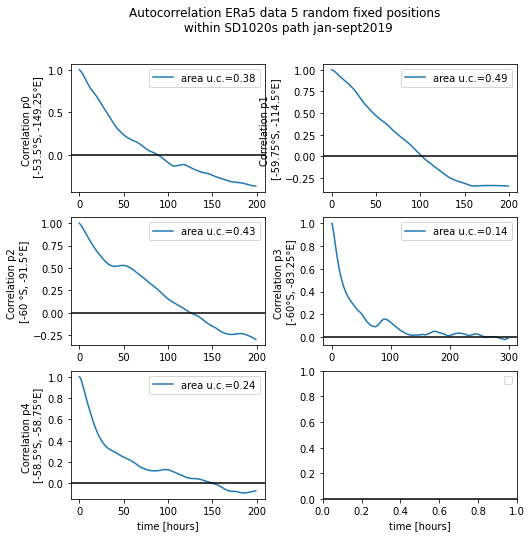

In [108]:
def area_under_curve_zerocrossing(ys):
    
    zero=np.where(np.array(ys) < 0)[0][0]
    xs=np.arange(0, 1, 1/zero)
    return np.trapz(ys[:zero], xs)

fig, ((ax1, ax2),( ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 8))
#fig.suptitle('Autocorrelation Q_turb ERA5 : SD1020 path')

ax1.plot(autocorr_t0[:200], label='area u.c.='+ str(np.round(area_under_curve_zerocrossing(autocorr_t0[:200]), 2)) )
ax2.plot(autocorr_t1[:200], label='area u.c.='+ str(np.round(area_under_curve_zerocrossing(autocorr_t1[:200]), 2)) )
ax3.plot(autocorr_t2[:200], label='area u.c.='+ str(np.round(area_under_curve_zerocrossing(autocorr_t2[:200]), 2)) )
ax4.plot(autocorr_t3[:300], label='area u.c.='+ str(np.round(area_under_curve_zerocrossing(autocorr_t3[:300]), 2)) )
ax5.plot(autocorr_t4[:200], label='area u.c.='+ str(np.round(area_under_curve_zerocrossing(autocorr_t4[:200]), 2)) ) 

ax1.set_ylabel('Correlation p0 \n [-53.5°S, -149.25°E]')
ax2.set_ylabel('Correlation p1 \n[-59.75°S, -114.5°E]')
ax3.set_ylabel('Correlation p2 \n[-60 °S, -91.5°E]')
ax4.set_ylabel('Correlation p3 \n[-60°S, -83.25°E]')
ax5.set_ylabel('Correlation p4 \n[-58.5°S, -58.75°E]')

ax5.set_xlabel('time [hours]')
ax6.set_xlabel('time [hours]')
#fig.subplots_adjust(hspace = 1)
fig.subplots_adjust(wspace=0.3)
axes=[ax1, ax2, ax3, ax4, ax5, ax6]
for a in axes:
    a.axhline(0,c= 'k')
    a.legend()
fig.suptitle('Autocorrelation ERa5 data 5 random fixed positions \n within SD1020s path jan-sept2019')    
#fig.savefig("Sdpaper_figs\Autocorrlation_Q_turb_era5_sd1020fixposition_timevariable_AUC.png", bbox_inches='tight', transparent=False)

## B: following Saildrone path and time: 


In [27]:
from datetime import datetime, timedelta #
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))
time_rounded=[]
l= len(traj_dublicates.dropna().index)
for i in np.arange(l):
    time_rounded.append(hour_rounder(traj_dublicates.dropna().index[i])) # because of nans in the GPS , I eliminated the nans first and then unsered th index of the remaining locations to round the time to hourly
    

In [28]:
#time_rounded= hour_rounder(df['1020'].index)

Q_turb_p0=[]
l = len(time_rounded)-1
for i in np.arange(l): 
    era_path_sens= era_sens.sel(latitude=traj_tubles_d[i][0],longitude=traj_tubles_d[i][1],time= time_rounded[i], method='nearest')
    era_path_lat= era_lat.sel(latitude=traj_tubles_d[i][0],longitude=traj_tubles_d[i][1],time= time_rounded[i], method='nearest')
    #Q_turb_p0.append((era_path_sens.values/3600)+(era_path_lat.values/3600))
    Q_turb_p0.append((era_path_sens/3600)+(era_path_lat/3600))# to get meta data on location &time remove values from this line and rerun
    #print(era_path_sens)

In [29]:
s= set([float(i.values) for i in Q_turb_p0])
Q_turb_p0_unique = []
for i in [float(i.values) for i in Q_turb_p0]:
    if i in Q_turb_p0_unique:
        continue
    else:
        Q_turb_p0_unique.append(i)
#Q=xr.DataArray(Q_turb_p0[:10])
#Q_turb_p0_unique= xr.Q_turb_p0.drop_duplicates()
len(Q_turb_p0_unique)   ####get the 

1566

In [ ]:
# save this stuff because it takes 4 ever to run
np.savetxt('Sdpaper_figs/colocated_pathandtime_ERA5_Qturb.txt', Q_turb_p0)

In [ ]:
Q_turb_p0= 

In [31]:
#plt.plot(Q_turb_p0)
# define autcorrelation: 
def autocovariance(Xi, N, k, Xs):
    autoCov = 0
    for i in np.arange(0, N-k):
        autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
    return (1/(N-1))*autoCov

def autocorrelation():
    return autocovariance(Xi, N, k, Xs) / autocovariance(Xi, N, 0, Xs)

Xi = Q_turb_p0_unique#Q_turb_p0#.values
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_pt=[]
autocovar_pt=[]
l= np.size(Xi)-1 
a0=  autocovariance(Xi, N, 0, Xs)
for i in np.arange(l):
     
    autocovar= autocovariance(Xi, N, i, Xs)
    autocorr_pt.append(autocovar/a0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [106]:
#Q_turb_p0_unique= np.unique(Q_turb_p0)
#print(len(Q_turb_p0))
#print(len(Q_turb_p0_unique))

65497


In [82]:
np.savetxt('Sdpaper_figs/colocated_pathandtime_ERA5_Qturb_autocorr.txt', autocorr_pt)

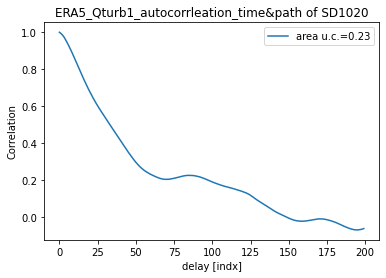

In [110]:
ys=autocorr_pt[:200]
xs=np.arange(0, 1, 1/len(ys))

plt.plot(autocorr_pt[:200], label='area u.c.='+ str(np.round(np.trapz(ys, xs), 2)))
plt.xlabel('delay [indx]')
plt.ylabel('Correlation')
plt.legend()
plt.title('ERA5_Qturb1_autocorrleation_time&path of SD1020')
#plt.savefig("Sdpaper_figs/Autocorrlation_Q_turb_era5_colo_time&path_AUC.jpg", bbox_inches='tight', transparent=False)

## C: fixed time, positions on path

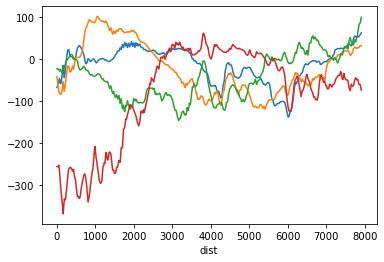

In [34]:

era_path_sens= era_sens.sel(latitude=traj['latitude'],longitude=traj['longitude'], method='nearest')
era_path_lat= era_lat.sel(latitude=traj['latitude'],longitude=traj['longitude'], method='nearest')

Q_sens_t0=era_path_sens.isel(time= 0)
Q_lat_t0= era_path_lat.isel(time= 0)
Q_turb_t0 = xr.DataArray((np.diagonal(Q_sens_t0)/3600)+(np.diagonal(Q_lat_t0)/3600),
                    dims=['dist'],
                    coords={'dist':np.insert(d,0,0)})

Q_sens_t1=era_path_sens.isel(time= 139)
Q_lat_t1= era_path_lat.isel(time= 139)
Q_turb_t1 = xr.DataArray((np.diagonal(Q_sens_t1)/3600)+(np.diagonal(Q_lat_t1)/3600),
                    dims=['dist'],
                    coords={'dist':np.insert(d,0,0)})


Q_sens_t2=era_path_sens.isel(time= 1781)
Q_lat_t2= era_path_lat.isel(time= 1781)
Q_turb_t2 = xr.DataArray((np.diagonal(Q_sens_t2)/3600)+(np.diagonal(Q_lat_t2)/3600),
                    dims=['dist'],
                    coords={'dist':np.insert(d,0,0)})

Q_sens_t4=era_path_sens.isel(time= 3557)
Q_lat_t4= era_path_lat.isel(time= 3557)
Q_turb_t4 = xr.DataArray((np.diagonal(Q_sens_t4)/3600)+(np.diagonal(Q_lat_t4)/3600),
                    dims=['dist'],
                    coords={'dist':np.insert(d,0,0)})

Q_sens_t5=era_path_sens.isel(time= 3286)
Q_lat_t5= era_path_lat.isel(time= 3286)
Q_turb_t5 = xr.DataArray((np.diagonal(Q_sens_t5)/3600)+(np.diagonal(Q_lat_t5)/3600),
                    dims=['dist'],
                    coords={'dist':np.insert(d,0,0)})
#ERA5_new
#len(np.where(~np.isnan(df['1020']['latitude']))[0])
Q_turb_t0.plot()
Q_turb_t1.plot()
Q_turb_t2.plot()
#Q_turb_t3.plot()
Q_turb_t4.plot()

In [35]:
def autocovariance(Xi, N, k, Xs):
    autoCov = 0
    for i in np.arange(0, N-k):
        autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
    return (1/(N-1))*autoCov

def autocorrelation():
    return autocovariance(Xi, N, k, Xs) / autocovariance(Xi, N, 0, Xs)

# Autocorreletion
Xi = Q_turb_t0.values
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_t0=[]
autocovar_t0=[]
l= np.size(Xi)-1 
for i in np.arange(l):
    autocovar_t0.append(autocovariance(Xi, N, i, Xs))
    autocorr_t0.append(autocovariance(Xi, N, i, Xs)/ autocovariance(Xi, N, 0, Xs))

    # Autocorreletion
Xi = Q_turb_t1.values
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_t1=[]
autocovar_t1=[]
l= np.size(Xi)-1 
for i in np.arange(l):
    autocovar_t1.append(autocovariance(Xi, N, i, Xs))
    autocorr_t1.append(autocovariance(Xi, N, i, Xs)/ autocovariance(Xi, N, 0, Xs))
    
Xi = Q_turb_t2.values
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_t2=[]
autocovar_t2=[]
l= np.size(Xi)-1 
for i in np.arange(l):
    autocovar_t2.append(autocovariance(Xi, N, i, Xs))
    autocorr_t2.append(autocovariance(Xi, N, i, Xs)/ autocovariance(Xi, N, 0, Xs))
    
Xi = Q_turb_t3.values
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_t3=[]
autocovar_t3=[]
l= np.size(Xi)-1 
for i in np.arange(l):
    autocovar_t3.append(autocovariance(Xi, N, i, Xs))
    autocorr_t3.append(autocovariance(Xi, N, i, Xs)/ autocovariance(Xi, N, 0, Xs))
    
Xi = Q_turb_t4.values
N = np.size(Xi)
Xs = np.average(Xi)
autocorr_t4=[]
autocovar_t4=[]
l= np.size(Xi)-1 
for i in np.arange(l):
    autocovar_t4.append(autocovariance(Xi, N, i, Xs))
    autocorr_t4.append(autocovariance(Xi, N, i, Xs)/ autocovariance(Xi, N, 0, Xs))

NameError: name 'Q_turb_t3' is not defined

In [ ]:
def area_under_curve_zerocrossing(ys):
    
    zero=np.where(np.array(ys) < 0)[0][0]
    xs=np.arange(0, 1, 1/zero)
    return np.trapz(ys[:zero], xs)

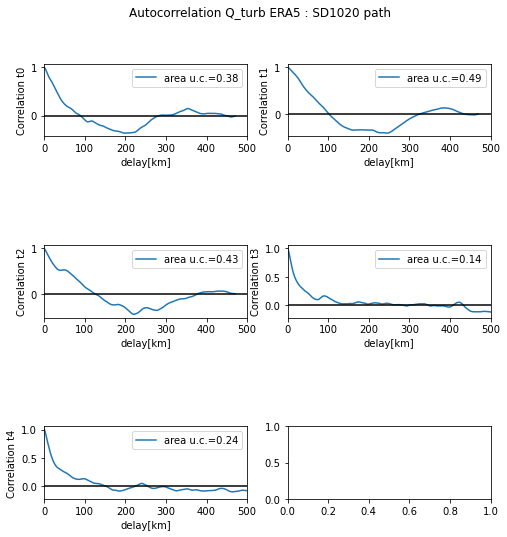

In [111]:
# compare the three plots 
# note: SDs need about 7 days for 1'000 km
fig, ((ax1, ax2),( ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 8))
fig.suptitle('Autocorrelation Q_turb ERA5 : SD1020 path')

ys=autocorr_t0
xs=np.arange(0, 1, 1/len(ys))

ax1.plot(autocorr_t0, label='area u.c.='+ str(np.round(area_under_curve_zerocrossing(autocorr_t0), 2)))
ax2.plot(autocorr_t1, label='area u.c.='+ str(np.round(area_under_curve_zerocrossing(autocorr_t1), 2)))
ax3.plot(autocorr_t2, label='area u.c.='+ str(np.round(area_under_curve_zerocrossing(autocorr_t2), 2)))

ax4.plot(autocorr_t3, label='area u.c.='+ str(np.round(area_under_curve_zerocrossing(autocorr_t3), 2)))
ax5.plot(autocorr_t4, label='area u.c.='+ str(np.round(area_under_curve_zerocrossing(autocorr_t4), 2)))




ax1.set_ylabel('Correlation t0')
ax2.set_ylabel('Correlation t1')
ax3.set_ylabel('Correlation t2')
ax4.set_ylabel('Correlation t3')
ax5.set_ylabel('Correlation t4')
fig.subplots_adjust(hspace = 1.5) #FIXME: for better layout USE NEXT TIME: fig.subplots_adjust(wspace=0.3)
for a in [ax1, ax2, ax3, ax4, ax5]: 
    a.axhline(0,c='k')
    a.set_xlabel('delay[km]')
    a.legend()
    a.set_xlim(0, 500)
#plt.savefig("Sdpaper_figs/Autocorrlation_Q_turb_era4_sd1020path_fixed_time_AUC.jpg", bbox_inches='tight', transparent=False)

## STOP AUTOCOREELATION 

In [20]:
def subsamling_1DS_per_subsample(data, max_res): 
    '''
    input:
    data:data to subsample in array 
    max_res: maximal subsampling frequency (steps of 1 so far)
    
    outut: 
    all_means: means of all subsampled data sets, in list of array, where diffrent means for a sampling frequency mean diffrent starting points 
    mean: mean of all means of the data set from the same sampling frequency
    std: std of the mean of means from same sampling frequency
    corresponding sampling freq: range(1, max_res)
    
    '''
    means=[]
    std=[]
    mean=[]
    all_means=[]
    d=[]
    for i in range(1, max_res):# max reampled res 25km
        means=[]
        d_i=data[::i]
        d.append(d_i)
        mean.append(np.nanmean(d_i))
        #print(means)
        #all_means.append(means)
        #mean.append(np.nanmean(means))
        std.append(np.nanstd(d_i))     
    return all_means, mean, std, d

In [18]:
# just one subsampled data set per sampling frequency 
sub_20_1=  subsamling_1DS_per_subsample(regrid_Qturb_1020, 100)

all_1020= sub_20_1[3]
mean_1020= sub_20_1[1]
std_1020= sub_20_1[2]

sub_22_1=  subsamling_1DS_per_subsample(regrid_Qturb_1022, 100)

all_1022= sub_22_1[3]
mean_1022= sub_22_1[1]
std_1022= sub_22_1[2]

sub_23_1=  subsamling_1DS_per_subsample(regrid_Qturb_1023, 100)

all_1023= sub_23_1[3]
mean_1023= sub_23_1[1]
std_1023= sub_23_1[2]


NameError: name 'regrid_Qturb_1020' is not defined

In [13]:
bins_mean_22=[]
bins_mean_23=[]
bins_mean_20=[]
for l in np.arange(0, 98):
    bins_mean_22.append(plt.hist(all_1022[l], density=True, bins=np.arange(-160,100,1))[0])
    bins_mean_23.append(plt.hist(all_1023[l], density=True, bins=np.arange(-160,100,1))[0])
    bins_mean_20.append(plt.hist(all_1020[l], density=True, bins=np.arange(-100,100,1))[0])


NameError: name 'all_1022' is not defined

In [14]:
std_plus_1020=[]
std_minus_1020=[]
std_plus_1022=[]
std_minus_1022=[]
std_plus_1023=[]
std_minus_1023=[]
for i in np.arange(0,99):
    std_plus_1020.append(mean_1020[i]+std_1020[i])
    std_minus_1020.append(mean_1020[i]-std_1020[i])
    std_plus_1022.append(mean_1022[i]+std_1022[i])
    std_minus_1022.append(mean_1022[i]-std_1022[i])
    std_plus_1023.append(mean_1023[i]+std_1023[i])
    std_minus_1023.append(mean_1023[i]-std_1023[i])

NameError: name 'mean_1020' is not defined

<ipython-input-26-2eb471447d59>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c0 = ax0.pcolor(X1, Y1,b_20.transpose(), cmap='inferno_r', vmin= 0.1, vmax=20, norm=matplotlib.colors.LogNorm())
<ipython-input-26-2eb471447d59>:21: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  c0 = ax0.pcolor(X1, Y1,b_20.transpose(), cmap='inferno_r', vmin= 0.1, vmax=20, norm=matplotlib.colors.LogNorm())
<ipython-input-26-2eb471447d59>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify t

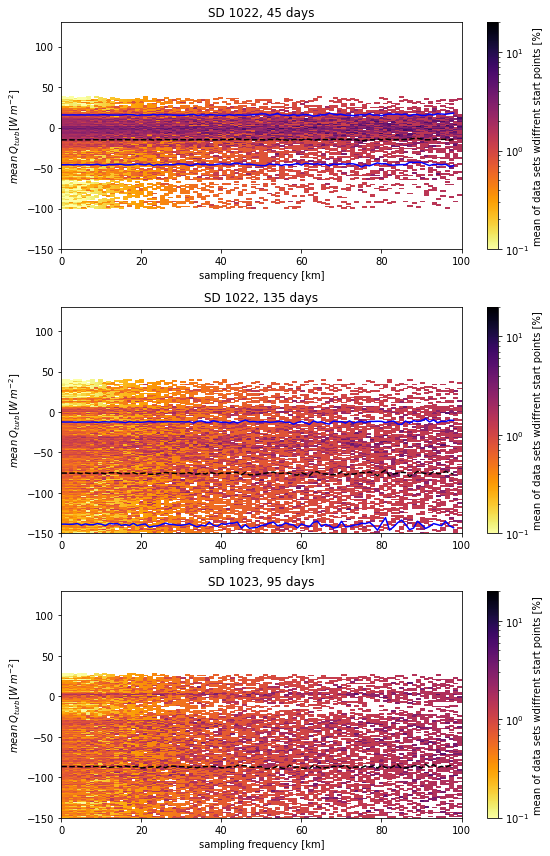

In [26]:
# subsampling one itteration step, starting a 0, no means taken here 

#plt.plot(mean)
#plt.plot(std_plus)
#plt.plot(std_minus)
#colors: 
c2='blue' #color for std line 
import matplotlib
b_20 = (np.array(bins_mean_20))*100
b_22=(np.array(bins_mean_22))*100
b_23= (np.array(bins_mean_23))*100

X, Y = np.meshgrid(np.linspace(0, 100, 98), np.linspace(-160, 100, 259))
X1, Y1 = np.meshgrid(np.linspace(0, 100, 98), np.linspace(-100, 100, 199))
fig, (ax0, ax1,  ax2) = plt.subplots(3, 1, figsize=[8,12])

#c = ax0.pcolor(X, Y, np.array(means).transpose(), cmap='inferno')#, shading='auto')#,
               #norm=LogNorm(vmin=Z.min(), vmax=Z.max()), cmap='PuBu_r')
#fig.colorbar(c, ax=ax0, label='% of histogram')

c0 = ax0.pcolor(X1, Y1,b_20.transpose(), cmap='inferno_r', vmin= 0.1, vmax=20, norm=matplotlib.colors.LogNorm())
ax0.plot(mean_1020,'--', color= 'k')
ax0.plot(std_plus_1020, color= c2)
ax0.plot(std_minus_1020, color= c2)
ax0.title.set_text('SD 1022, 45 days')
fig.colorbar(c0, ax=ax0, label= 'mean of data sets wdiffrent start points [%]')

#ax0.set_ylim(-50,50)
c1 = ax1.pcolor(X, Y,b_22.transpose(), cmap='inferno_r', vmin= 0.1, vmax=20, norm=matplotlib.colors.LogNorm())
ax1.plot(mean_1022,'--', color= 'k')
ax1.plot(std_plus_1022, color= c2)
ax1.plot(std_minus_1022, color= c2)
ax1.title.set_text('SD 1022, 135 days')
fig.colorbar(c1, ax=ax1, label= 'mean of data sets wdiffrent start points [%]')


c2 = ax2.pcolor(X, Y,b_23.transpose(), cmap='inferno_r', vmin= 0.1, vmax=20, norm=matplotlib.colors.LogNorm())
ax2.plot(mean_1023,'--', color= 'k')
#ax2.plot(std_plus_1022, color= c2)
#ax2.plot(std_minus_1023, color=c2)
ax2.title.set_text('SD 1023, 95 days')

fig.colorbar(c2, ax=ax2, label= 'mean of data sets wdiffrent start points [%]')
axes=[ax0, ax1, ax2]
for a in axes:
    a.set_ylabel('$mean\:Q_{turb} [W\:m^{-2}]$')
    a.set_xlabel('sampling frequency [km]')
    a.set_ylim(-150, 130)
fig.tight_layout()  
#fig.savefig("Add_analysis_Q_turb_scaleanalysis_comp_1ds.png", bbox_inches='tight', transparent=True)

In [19]:
##THIS is a must
sub_20=  subsamling_means(regrid_Qturb_1020, 100)

all_means_1020= sub_20[0]
mean_1020= sub_20[1]
std_1020= sub_20[2]

sub_22=  subsamling_means(regrid_Qturb_1022, 100)

all_means_1022= sub_22[0]
mean_1022= sub_22[1]
std_1022= sub_22[2]

sub_23=  subsamling_means(regrid_Qturb_1023, 100)

all_means_1023= sub_23[0]
mean_1023= sub_23[1]
std_1023= sub_23[2]

std_plus_1020=[]
std_minus_1020=[]
std_plus_1022=[]
std_minus_1022=[]
std_plus_1023=[]
std_minus_1023=[]
for i in np.arange(0,99):
    std_plus_1020.append(mean_1020[i]+std_1020[i])
    std_minus_1020.append(mean_1020[i]-std_1020[i])
    std_plus_1022.append(mean_1022[i]+std_1022[i])
    std_minus_1022.append(mean_1022[i]-std_1022[i])
    std_plus_1023.append(mean_1023[i]+std_1023[i])
    std_minus_1023.append(mean_1023[i]-std_1023[i])
    

NameError: name 'regrid_Qturb_1020' is not defined

In [15]:
bound=(0,5)
bound20=(0,25)
bound23=(0,25)

y_alt_20= np.arange(bound20[0]-.0625,bound20[1]+.125+.0625,0.125)-bound20[1]/2+all_means_1020[0]
y_alt_23= np.arange(bound23[0]-.0625,bound23[1]+.125+.0625,0.125)-bound23[1]/2+all_means_1023[0]

#y_alt=np.arange(bound[0]-.0625,bound[1]+.125+.0625,0.125)-bound[1]/2+all_means_1023[0]

NameError: name 'all_means_1020' is not defined

C:\Users\Public\Anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


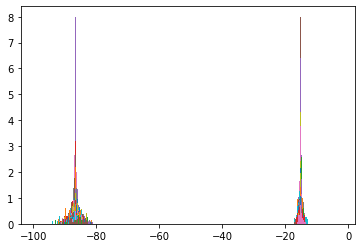

In [32]:
bins_mean_22=[]
bins_mean_23=[]
bins_mean_20=[]
for l in np.arange(0, 99):
    bins_mean_22.append(plt.hist(all_means_1022[l], density=True, bins=np.arange(-50, 10, 1))[0])
    bins_mean_23.append(plt.hist(all_means_1023[l], density=True, bins=y_alt_23)[0])
    bins_mean_20.append(plt.hist(all_means_1020[l], density=True, bins=y_alt_20)[0])

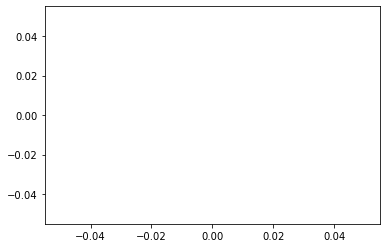

In [33]:
### for backwards cuts()

bins_mean_zoom_22=[]
bins_mean_zoom_23=[]
bins_mean_zoom_20=[]
for l in np.arange(0, 25):
    bins_mean_zoom_22.append(plt.hist(all_means_1022[l], density=True, bins=np.arange(-17,-12,0.125))[0]) # in first 25km max: -12 , min:-16.1
    bins_mean_zoom_23.append(plt.hist(all_means_1023[l], density=True, bins=np.arange(0,10,0.125))[0])
    bins_mean_zoom_20.append(plt.hist(all_means_1020[l], density=True, bins=np.arange(-0.5,1.5,0.125))[0])

In [27]:
bound=(0,5)
y_alt=np.arange(bound[0]-.0625,bound[1]+.125+.0625,0.125)-bound[1]/2+all_means_1023[0]

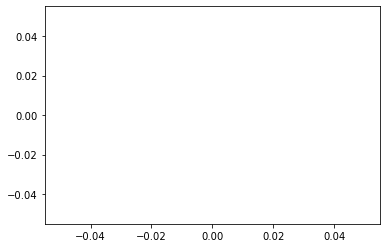

In [28]:
#### first 45 days ###########

bins_mean_zoom_22=[]
bins_mean_zoom_23=[]
bins_mean_zoom_20=[]
for l in np.arange(0, 25):
    bins_mean_zoom_22.append(plt.hist(all_means_1022[l], density=True, bins=np.arange(-1, 1.5, 0.125))[0]) # in first 25km max: -12 , min:-16.1
    bins_mean_zoom_23.append(plt.hist(all_means_1023[l], density=True, bins=np.arange(-30, -25, 0.125))[0])
    bins_mean_zoom_20.append(plt.hist(all_means_1020[l], density=True, bins=np.arange(-0.5, 1.5, 0.125))[0])

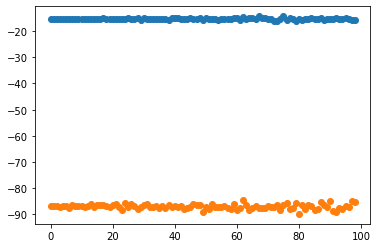

In [33]:
star_20= [y_alt_20[np.where(bins_mean_20[i]== np.max(bins_mean_20[i]))[0][0]] for i in range(99)]
star_23= [y_alt_23[np.where(bins_mean_23[i]== np.max(bins_mean_23[i]))[0][0]] for i in range(99)]
plt.scatter(range(99), star_20)
plt.scatter(range(99), star_23)

In [34]:
############# Abweichung von mean: 
k_rel2_mean_20=pd.DataFrame(all_means_1020)-all_means_1020[0][0]

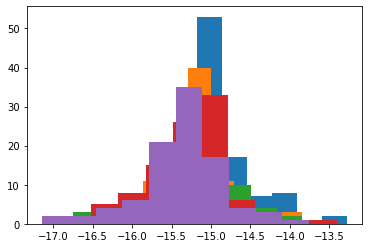

In [33]:
for i in range(5):
    plt.hist(pd.DataFrame(all_means_1020)[i])
plt.show()

In [34]:
p_95_20= [np.percentile(all_means_1020[i],95) for i in range(99)]
p_95_22= [np.percentile(all_means_1022[i],95) for i in range(99)]
p_95_23= [np.percentile(all_means_1023[i],95) for i in range(99)]

p_5_20= [np.percentile(all_means_1020[i],5) for i in range(99)]
p_5_22= [np.percentile(all_means_1022[i],5) for i in range(99)]
p_5_23= [np.percentile(all_means_1023[i],5) for i in range(99)]

In [31]:
bins_20= np.arange(-25,15,0.25)
bins_22= np.arange(-25,15,0.25)
bins_23= np.arange(-25,15,0.25)
k_20=[]
[k_20.append(bins_20[np.where(bins_mean_20[i]==np.max(bins_mean_20[i]))[0]]) for i in range(len(bins_mean_20))]
k_23=[]
[k_23.append(bins_23[np.where(bins_mean_23[i]==np.max(bins_mean_23[i]))[0]]) for i in range(len(bins_mean_23))]


#len(k_23)

99

TypeError: Dimensions of C (199, 99) are incompatible with X (99) and/or Y (159); see help(pcolor)

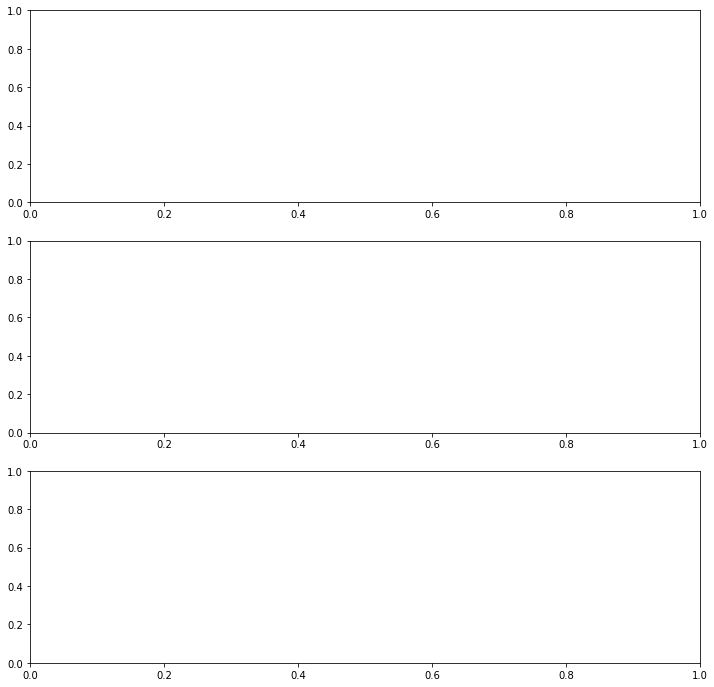

In [29]:
### with zoomed##### plot with only two panels: 
#plt.plot(mean)
#plt.plot(std_plus)
#plt.plot(std_minus)
import matplotlib
b_20 = (np.array(bins_mean_20)/8)*100
b_22=(np.array(bins_mean_22)/8)*100
b_23= (np.array(bins_mean_23)/8)*100

X, Y = np.meshgrid(np.linspace(1, 100, 99), np.linspace(-25, 15,159))
X1, Y1 = np.meshgrid(np.linspace(1, 100, 99), np.linspace(-25, 15,159))
fig, (ax0, ax1,ax2) = plt.subplots(3, 1, figsize=[12,12])

#c = ax0.pcolor(X, Y, np.array(means).transpose(), cmap='inferno')#, shading='auto')#,
               #norm=LogNorm(vmin=Z.min(), vmax=Z.max()), cmap='PuBu_r')
#fig.colorbar(c, ax=ax0, label='% of histogram')

c0 = ax0.pcolor(X1, Y1,b_20.transpose(), cmap='inferno_r', vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())
ax0.plot(mean_1020,'--', color= 'k')
#ax0.plot(std_plus_1020, color= 'grey')
#ax0.plot(std_minus_1020, color= 'grey')
ax0.title.set_text('SD 1020')
fig.colorbar(c0, ax=ax0, label= 'mean of data sets wdiffrent start points [%]')
[ax0.scatter(xaxis_20[i]+1.5,k_20[i]+0.2,marker= '*', color='w', alpha=0.7)for i in range(99)]
ax0.plot(p_95_20, c='blue',linewidth=3, label='95th percentile of means')
ax0.plot(p_5_20, c='blue',linewidth=3, label='5th percentile of means')
ax0.legend(loc='upper left')

ax1.plot(mean_1022,'--', color= 'k')
c0 = ax1.pcolor(X1, Y1,b_22.transpose(), cmap='inferno_r', vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())
ax1.title.set_text('SD 1022')
fig.colorbar(c0, ax=ax1, label= 'mean of data sets wdiffrent start points [%]')
[ax1.scatter(xaxis_20[i]+1.5,k_20[i]+0.2,marker= '*', color='w', alpha=0.7)for i in range(99)]
ax1.plot(p_95_22, c='blue',linewidth=3, label='95th percentile of means')
ax1.plot(p_5_22, c='blue',linewidth=3, label='5th percentile of means')
ax1.legend(loc='upper left')

c2 = ax2.pcolor(X, Y,b_23.transpose(), cmap='inferno_r', vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())
ax2.plot(mean_1023,'--', color= 'k')
#ax1.plot(std_plus_1023, color= 'grey')
#ax1.plot(std_minus_1023, color= 'grey')
ax2.title.set_text('SD 1023')
[ax2.scatter(xaxis_23[i]+1.5,k_23[i]+0.2,marker= '*', color='w', alpha=0.7)for i in range(99)]
fig.colorbar(c2, ax=ax2, label= 'mean of data sets diffrent start points [%]')
ax2.plot(p_95_23, c='blue',linewidth=3, label='95th percentile of means')
ax2.plot(p_5_23, c='blue',linewidth=3, label='5th percentile of means')
ax2.legend(loc='lower left')
axes=[ax0, ax1]
for a in axes:
    a.set_ylabel('$mean\:Q_{turb} [W\:m^{-2}]$')
    a.set_xlabel('sampling frequency [km]')
    a.set_xlim(0,100)
fig.tight_layout()   
#fig.savefig("Add_analysis_Q_turb_scaleanalysis_comp_gam_last45 days2223.png", bbox_inches='tight')#, transparent=True)

In [31]:
b_20 = (np.array(bins_mean_20)/8)*100
b_22=(np.array(bins_mean_22)/8)*100
b_23= (np.array(bins_mean_23)/8)*100
len(b_22[0])

59

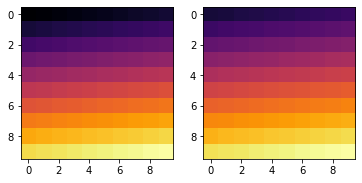

In [225]:
######################new colorbar without black 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('inferno')
new_cmap = truncate_colormap(cmap, 0.1, 1)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
#plt.show()
c= matplotlib.cm.get_cmap(new_cmap, 18)


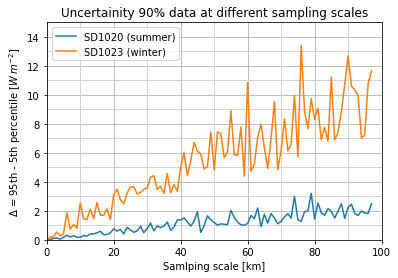

In [54]:
delta_23= np.zeros(98)
delta_20= np.zeros(98)
for i in range(98):
    delta_23[i] = abs(p_5_23[i]-p_95_23[i])
    delta_20[i] = abs(p_5_20[i]-p_95_20[i])
c = 'lightgrey'    
plt.plot( delta_20, label='SD1020 (summer)')
plt.plot( delta_23, label= 'SD1023 (winter)')
plt.hlines(1, 0, 100, color= c, linewidth=1)
plt.hlines(3, 0, 100, color= c, linewidth=1)
plt.hlines(5, 0, 100, color= c, linewidth=1)
plt.hlines(7, 0, 100, color= c, linewidth=1)
plt.hlines(9, 0, 100, color= c, linewidth=1)
plt.hlines(11, 0, 100, color= c, linewidth=1)
plt.hlines(13, 0, 100, color= c, linewidth=1)

plt.vlines(10, 0, 20, color= c, linewidth=1)
plt.vlines(30, 0, 20, color= c, linewidth=1)
plt.vlines(50, 0, 20, color= c, linewidth=1)
plt.vlines(70, 0, 20, color= c, linewidth=1)
plt.vlines(90, 0, 20, color= c, linewidth=1)



plt.xlabel('Samlping scale [km]')
plt.ylabel('Δ = 95th - 5th percentile [$W\:m^{-2}$]')
plt.xlim(0, 100)
plt.ylim(0, 15)

plt.legend()
plt.title('Uncertainity 90% data at different sampling scales')

y= np.arange(1, 13)
plt.grid(axis='y')
plt.grid(axis='x')
#plt.savefig("uncertain_scales.png", bbox_inches='tight')#, transparent=True)

<ipython-input-35-b0dfb31fa88e>:53: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  c0 = ax1.pcolor(X, Y, b_20.transpose(), cmap=cmap, vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())#, snap=True)
<ipython-input-35-b0dfb31fa88e>:58: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  c2 = ax2.pcolor(X3, Y3,b_23.transpose(), cmap=cmap, vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())
<ipython-input-35-b0dfb31fa88e>:65: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  c3 

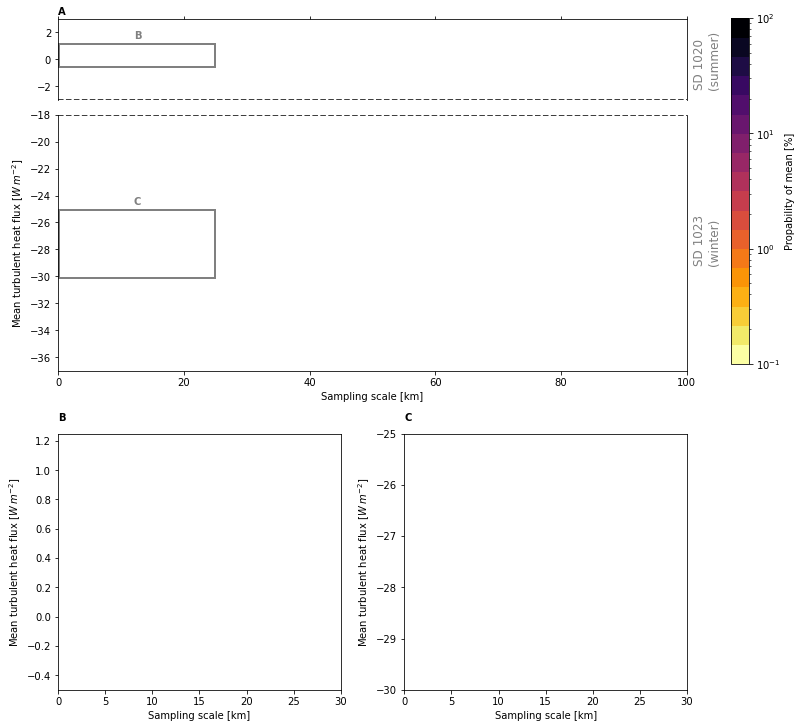

In [35]:
#### new figure: 
import matplotlib
import matplotlib.gridspec as gridspec

b_20 = (np.array(bins_mean_20)/8)*100
b_22=(np.array(bins_mean_22)/8)*100
b_23= (np.array(bins_mean_23)/8)*100

b_20_zoom= (np.array(bins_mean_zoom_20)/8)*100
b_22_zoom= (np.array(bins_mean_zoom_22)/8)*100
b_23_zoom= (np.array(bins_mean_zoom_23)/8)*100

cmap = matplotlib.cm.get_cmap("inferno_r", 18)

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
spec = gridspec.GridSpec(ncols=4, nrows=3, figure=fig, height_ratios=[6/19*1, 1, 1])
ax1 = fig.add_subplot(spec[0:1, :])
ax2 = fig.add_subplot(spec[1:2, :])
ax3 = fig.add_subplot(spec[2:, :2])
ax4 = fig.add_subplot(spec[2:, 2:])

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labelbottom=False) 
ax1.xaxis.tick_top()
#ax1.set_xticks([])
ax1.hlines(-3,0,100,linestyle='--', color= 'k')
ax2.hlines(-18,0,100,linestyle='--', color= 'k')
ax3.hlines((p_95_20[0]+.5625),0,100,linestyle='-', color= 'k')
ax3.hlines((p_95_20[0]-.5625),0,100,linestyle='-', color= 'k')

ax4.hlines((p_95_23[0]+.5625),0,100,linestyle='-', color= 'k')
ax4.hlines((p_95_23[0]-.5625),0,100,linestyle='-', color= 'k')

ax1.set_ylim(-3,3)
ax2.set_ylim(-37,-18)
axes= [ax1, ax2]
for a in axes: 
    a.set_xlim(0,100)
    #a.set_facecolor('k') # black background where there is no data


axes_small=[ax3,ax4]
for a in axes_small:
    a.set_xlim(0,30)
    #a.set_facecolor('k') # black background where there is no data
X, Y = np.meshgrid(np.linspace(.5, 99.5, 100), y_alt_20)
X3, Y3 = np.meshgrid(np.linspace(.5, 99.5, 100), y_alt_23)

c_per='#0271cc'#'#4965a8'#'royalblue'#'steelblue'#'grey'
l= 3

c0 = ax1.pcolor(X, Y, b_20.transpose(), cmap=cmap, vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())#, snap=True)
ax1.plot(np.linspace(1, 99, 99), p_95_20, c=c_per, linewidth=l-.5, label='95th percentile of means')
ax1.plot(np.linspace(1, 99, 99),p_5_20, c=c_per, linewidth=l-.5, label='5th percentile of means')

#c1 = ax2.pcolor(X3, Y3, b_23.transpose(), cmap=cmap, vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())
c2 = ax2.pcolor(X3, Y3,b_23.transpose(), cmap=cmap, vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())
ax2.plot(np.linspace(1, 99, 99), p_95_23, c=c_per, linewidth=l-.5, label='95th percentile of means')
ax2.plot(np.linspace(1, 99, 99),p_5_23, c=c_per, linewidth=l-.5, label='5th percentile of means')
ax2.set_yticks(np.arange(-36, -16, step=2))
#[ax2.scatter(xaxis_23[i]+1.5, k_23[i]+0.2, marker= '*', color='w', alpha=0.5)for i in range(90)]


c3 = ax3.pcolor(X, Y, b_20.transpose(), cmap=cmap, vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())
ax3.set_ylim(-.5,1.25)
ax3.plot(np.linspace(1, 99, 99), p_95_20, c=c_per, linewidth=l, label='95th percentile of means', alpha=0.6, zorder=1)
ax3.plot(np.linspace(1, 99, 99),p_5_20, c=c_per, linewidth=l, label='5th percentile of means', alpha=0.6, zorder=1)


##ax4 = fig.add_axes([0.18, 0.3, 0.2, 0.08])
c4 = ax4.pcolor(X3, Y3, b_23.transpose(), cmap=cmap, vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm(), snap=True)
ax4.plot(np.linspace(1, 99, 99), p_95_23, c=c_per, linewidth=l, label='95th percentile of means', alpha=0.6, zorder=1)
ax4.plot(np.linspace(1, 99, 99), p_5_23, c=c_per, linewidth=l, label='5th percentile of means', alpha=0.6, zorder=1)
ax4.set_ylim(-30, -25)


axes= [ax2, ax3, ax4]
for a in axes:
    a.set_xlabel('Sampling scale [km]')
    a.set_ylabel('Mean turbulent heat flux [$W\:m^{-2}$]')
    #a.set_facecolor('k') # black background where there is no data
#fig.subplots_adjust(top=1)
#fig.colorbar(c2, ax=ax2, label= 'mean of data sets wdiffrent start points [%]')
cbar_ax = fig.add_axes([1.01, 0.5, 0.025, 0.48])
fig.colorbar(c0, cax=cbar_ax  , label= 'Propability of mean [%]')
ax1.annotate('A',xy=[0, 1.05], xycoords='axes fraction', color='k', weight='bold')
ax1.annotate('B',xy=[0.12, 0.75], xycoords='axes fraction', color='gray', weight='bold')
ax2.annotate('C',xy=[0.12, 0.65], xycoords='axes fraction', color='gray', weight='bold')

ax3.annotate('B',xy=[0, 1.05], xycoords='axes fraction', color='k', weight='bold')
ax4.annotate('C',xy=[0, 1.05], xycoords='axes fraction', color='k', weight='bold')

ax1.text(101,-2,'SD 1020\n(summer)', rotation=90, fontsize= 12, color= 'grey')
ax2.text(101,-29,'SD 1023\n(winter)', rotation=90, fontsize= 12, color= 'grey')
xaxis_20=np.linspace(1, 99, 99)
#axis_23=np.linspace(1, 101, 100)
co='steelblue'
a=1
[ax3.scatter(xaxis_20[i], star_20[i]+0.0625, marker= 'o', color=co, alpha= a, s=20, zorder=2) for i in range(30)]
[ax4.scatter(xaxis_20[i], star_23[i]+0.0625, marker= 'o', color=co, alpha=a, s=10, zorder=2) for i in range(30)]

import matplotlib.patches as patches
from matplotlib.patches import Rectangle
#ax3.scatter(np.linspace(1, 99, 99), star_20)
#plt.scatter(range(99), star_23)

ax2.add_patch(Rectangle((25 - .1, -25 - .1), -24.8, -5, fill=None, alpha=1, color='gray', linewidth= 2))
ax1.add_patch(Rectangle((25 - .1, 1.25 - .1), -24.8, -1.75, fill=None, alpha=1, color='gray', linewidth= 2))
#fig.subplots_adjust(hspace = .05)
#fig.savefig("hässlich_blackf_stars_grey_blue.png", bbox_inches='tight')#, transparent=True)

In [140]:
bound=(0,5)y_alt=np.arange(bound[0]-.0625,bound[1]+.125+.0625,0.125)-bound[1]/2+all_means_1023[0]

TypeError: Dimensions of C (201, 99) are incompatible with X (100) and/or Y (31); see help(pcolor)

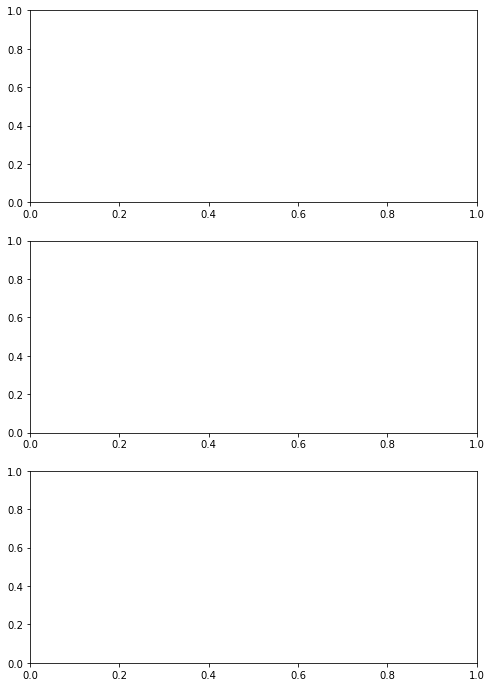

In [35]:
#plt.plot(mean)
#plt.plot(std_plus)
#plt.plot(std_minus)
import matplotlib
b_20 = (np.array(bins_mean_20)/8)*100
b_22=(np.array(bins_mean_22)/8)*100
b_23= (np.array(bins_mean_23)/8)*100

X, Y = np.meshgrid(np.linspace(0, 100, 99), np.linspace(-27, -12, 59))
X1, Y1 = np.meshgrid(np.linspace(0, 100, 100), np.linspace(-1.5, 2.5, 31))
fig, (ax0, ax1,  ax2) = plt.subplots(3, 1, figsize=[8,12])

#c = ax0.pcolor(X, Y, np.array(means).transpose(), cmap='inferno')#, shading='auto')#,
               #norm=LogNorm(vmin=Z.min(), vmax=Z.max()), cmap='PuBu_r')
#fig.colorbar(c, ax=ax0, label='% of histogram')

c0 = ax0.pcolor(X1, Y1,b_20.transpose(), cmap='inferno_r', vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())
ax0.plot(mean_1020,'--', color= 'k')
ax0.plot(std_plus_1020, color= 'grey')
ax0.plot(std_minus_1020, color= 'grey')
ax0.title.set_text('SD 1022')
fig.colorbar(c0, ax=ax0, label= 'mean of data sets wdiffrent start points [%]')
ax0.scatter(X1,k,'k')

#ax0.set_ylim(-50,50)
c1 = ax1.pcolor(X, Y,b_22.transpose(), cmap='inferno_r', vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())
ax1.plot(mean_1022,'--', color= 'k')
ax1.plot(std_plus_1022, color= 'grey')
ax1.plot(std_minus_1022, color= 'grey')
ax1.title.set_text('SD 1022')
fig.colorbar(c1, ax=ax1, label= 'mean of data sets wdiffrent start points [%]')


c2 = ax2.pcolor(X, Y,b_23.transpose(), cmap='inferno_r', vmin= 0.1, vmax=100, norm=matplotlib.colors.LogNorm())
ax2.plot(mean_1023,'--', color= 'k')
ax2.plot(std_plus_1023, color= 'grey')
ax2.plot(std_minus_1023, color= 'grey')
ax2.title.set_text('SD 1023')
fig.colorbar(c2, ax=ax2, label= 'mean of data sets wdiffrent start points [%]')
axes=[ax0, ax1, ax2]
for a in axes:
    a.set_ylabel('$mean\:Q_{turb} [W\:m^{-2}]$')
    a.set_xlabel('sampling frequency [km]')
fig.tight_layout()   
#fig.savefig("Add_analysis_Q_turb_scaleanalysis_comp.png", bbox_inches='tight', transparent=True)

In [59]:
subsample_1020= subsample_unique(regrid_Qturb_1020, 1, 100)
#subsample_1022= subsample(regrid_Qturb_1022, 1, 100)
#subsample_1023= subsample(regrid_Qturb_1023, 1, 100)

C:\Users\Hanna\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Hanna\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  22.,  101.,  354.,  917., 1100.,  413.,  158.,  108.,   36.,
           9.]), array([-56.54118033, -43.18234366, -29.82350698, -16.46467031,
         -3.10583364,  10.25300304,  23.61183971,  36.97067638,
         50.32951306,  63.68834973,  77.0471864 ]), <a list of 10 Patch objects>)

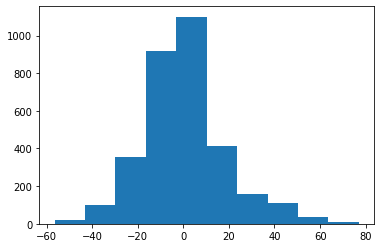

In [62]:
plt.hist(np.nanmean(subsample_1020[0]))

In [80]:
mean=[]
std=[]
sum_n=[]
sum_b=[]
for i in range(0,98):
    mean.append(np.nanmean(subsample_1020[i]))
    std.append(np.nanstd(subsample_1020[i]))
    sum_n.append(mean[i]+std[i])
    sum_b.append(mean[i]-std[i])

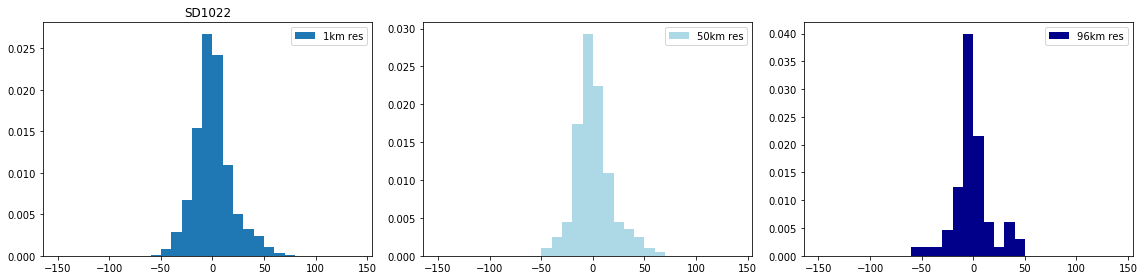

In [63]:
#### compare 3 sampling frequencies

l= [0,40, 97]
#
bins_n= np.arange(-150,150,10)
fig, (ax0, ax1, ax2)=  plt.subplots(1, 3, tight_layout=True, figsize=[16,4])
ax=[ax0,ax1,ax2]

ax0.set_title('SD1022')
ax0.hist(subsample_1020[0], density=True, bins=bins_n, label='1km res')
ax0.legend()
ax1.hist(subsample_1020[30], density=True, bins=bins_n, color='lightblue', label='50km res')
ax1.legend()
ax2.hist(subsample_1020[97], density=True, bins=bins_n, color='darkblue', label='96km res')
ax2.legend()
#fig.savefig("Add_analysis_Q_turb_pcolor_hist_3susampled_Sd1022_1wm2.png", bbox_inches='tight', transparent=True)

In [112]:
np.nanstd(subsample_1022[0][50])

25.487405818465074

In [19]:
# mean and spread 

mean_n_20=[]
std_n_20= []
mean_n_22=[]
std_n_22= []
mean_n_23=[]
std_n_23= []
sum_n20=[]
sum_n22=[]
sum_n23=[]
for i in range(0,97):
    mean_n_20.append(np.nanmean(subsample_1020[0][i]))
    std_n_20.append(np.nanstd(subsample_1020[0][i]))
    mean_n_22.append(np.nanmean(subsample_1022[0][i]))
    std_n_22.append(np.nanstd(subsample_1022[0][i]))
    mean_n_23.append(np.nanmean(subsample_1023[0][i]))
    std_n_23.append(np.nanstd(subsample_1023[0][i]))

for i in range(0,97):
    sum_n20.append(mean_n_20[i]+std_n_20[i])
    sum_n22.append(mean_n_22[i]+std_n_22[i])
    sum_n23.append(mean_n_23[i]+std_n_23[i])
    

NameError: name 'subsample_1020' is not defined

(0, 0.5)

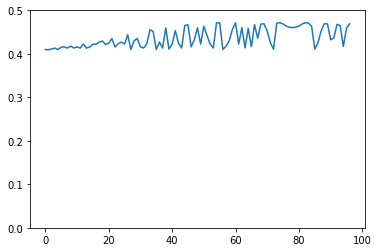

In [49]:
plt.plot(mean_n_20)
plt.ylim(0, 0.5)

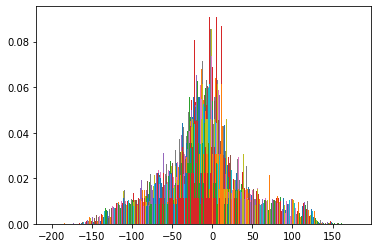

In [245]:
bins_1020=[]
bins_1022=[]
bins_1023=[]
for l in np.arange(0, 98):
    bins_1020.append(plt.hist(subsample_1020[0][l], density=True, bins=np.arange(-200,180,1))[0])
    bins_1022.append(plt.hist(subsample_1022[0][l], density=True, bins=np.arange(-200,180,1))[0])
    bins_1023.append(plt.hist(subsample_1023[0][l], density=True, bins=np.arange(-200,180,1))[0])
bins_1020=np.array(bins_1020)
bins_1022=np.array(bins_1022)
bins_1023=np.array(bins_1023)

In [247]:
####### save nc files ##############
np.savetxt('save_subsampled_bins_Qturb_1020.txt', bins_1020)
np.savetxt('save_subsampled_bins_Qturb_1022.txt', bins_1022)
np.savetxt('save_subsampled_bins_Qturb_1023.txt', bins_1023)

In [9]:
bins_1020=np.genfromtxt('save_subsampled_bins_Qturb_1020.txt') # bined with -200, 180, 1 km 
bins_1022=np.genfromtxt('save_subsampled_bins_Qturb_1022.txt')
bins_1023=np.genfromtxt('save_subsampled_bins_Qturb_1023.txt')

In [ ]:
N = 234
N1 = 98
X, Y = np.meshgrid(np.linspace(0, 100, N1), np.linspace(-55, 180, N))
fig, (ax0) = plt.subplots(1, 1)

c = ax0.pcolor(X, Y, np.array(bins).transpose(), cmap='inferno')#, shading='auto')#,
               #norm=LogNorm(vmin=Z.min(), vmax=Z.max()), cmap='PuBu_r')
fig.colorbar(c, ax=ax0, label='% of histogram')
ax0.set_ylabel('$Q_{sens} [W\:m^{-2}]$')
ax0.set_xlabel('sampling frequency')

#fig.savefig("Add_analysis_Q_sens_pcolor_hist.png", bbox_inches='tight', transparent=True)

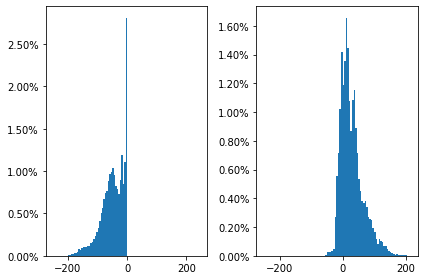

In [15]:
# plot relative 8 to the number of measurments)  Q sens/lat 
from matplotlib.ticker import PercentFormatter

n_bins= np.arange(-250, 220, 5)
ne_bins= np.arange(-250, 250, 5)

fig, axs = plt.subplots(1, 2, tight_layout=True)

axs[0].hist(interp_end.Q_lat, bins=ne_bins , density=True)
axs[0].yaxis.set_major_formatter(PercentFormatter(xmax=1))

axs[1].hist(interp_end.Q_sens, bins=n_bins , density=True)
axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
#axs[1].set_yscale('log')

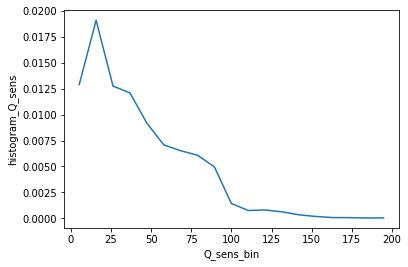

In [31]:
#xhistogram.xarray.Q_sens.histogram(density=True)
#interp_end
import xarray as xr
import numpy as np
#%matplotlib inline
import xhistogram
from xhistogram.xarray import histogram

#da = xr.DataArray(interp_end.Q_sens)
bins = np.linspace(0, 200, 20)
h_x = histogram(interp_end.Q_sens, bins=[bins], dim=['dist_NZ'], density=True)
h_x.plot()

In [40]:
# subsaming the data new code: 
def subsample(data, res_start, res_end, res):
    subs=np.zeros(res_end*res)
    for i in range(res_start, res_end, res):
        subsampled_n= []
        for j in range(0, i-1): 
            subsampled_n.append(np.array(data[j::i]))
        subs[i]=np.mean([subsampled_n], axis=0)
    return subs               
        

In [165]:
data= interp_end.Q_sens
res= 1
res_end= 100#int(len(data)/2)
res_start=0
k= subsample(data, res, res_end)

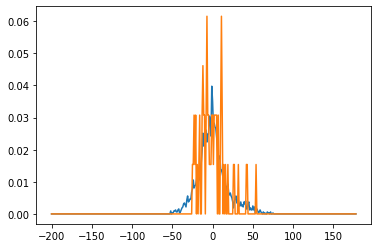

In [52]:
y= bins_1020[0]
y1= bins_1020[49]
y2= bins_1020[-1]

x= np.arange(-200,180,1)[:-1]
plt.plot(x,y)
#plt.plot(x,y1)
plt.plot(x,y2)
#plt.xlim(-60, 80)

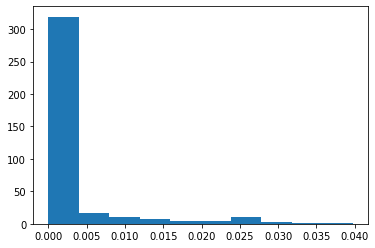

In [42]:
plt.hist(bins_1020[0])
plt.show()

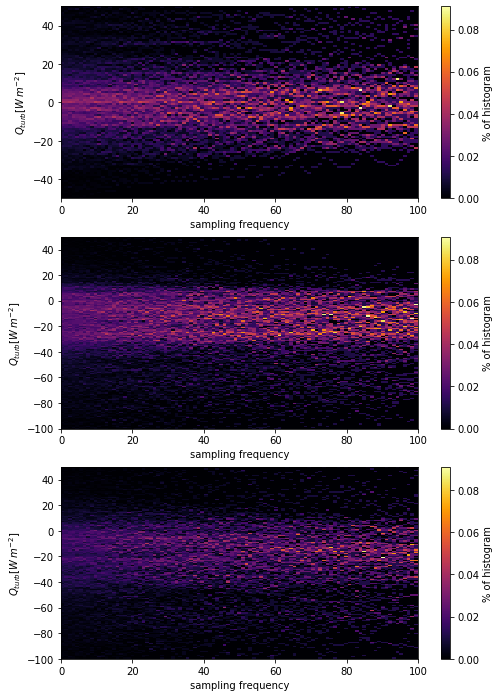

In [17]:
N = 379
N1 = 98
X, Y = np.meshgrid(np.linspace(0, 100, N1), np.linspace(-200, 180, N))
fig, (ax0, ax1,  ax2) = plt.subplots(3, 1, figsize=[8,12])

c = ax0.pcolor(X, Y, np.array(bins_1020).transpose(), cmap='inferno')#, shading='auto')#,
               #norm=LogNorm(vmin=Z.min(), vmax=Z.max()), cmap='PuBu_r')
fig.colorbar(c, ax=ax0, label='% of histogram')
ax0.set_ylabel('$Q_{turb} [W\:m^{-2}]$')
ax0.set_xlabel('sampling frequency')
ax0.set_ylim(-50,50)

c1 = ax1.pcolor(X, Y, np.array(bins_1022).transpose(), cmap='inferno')
fig.colorbar(c, ax=ax1, label='% of histogram')
ax1.set_ylabel('$Q_{turb} [W\:m^{-2}]$')
ax1.set_xlabel('sampling frequency')
ax1.set_ylim(-100,50)


c2 = ax2.pcolor(X, Y, np.array(bins_1023).transpose(), cmap='inferno')
fig.colorbar(c, ax=ax2, label='% of histogram')
ax2.set_ylabel('$Q_{turb} [W\:m^{-2}]$')
ax2.set_xlabel('sampling frequency')
ax2.set_ylim(-100,50)


#fig.savefig("Add_analysis_Q_turb_pcolor_hist_zoomed.png", bbox_inches='tight', transparent=True)

In [ ]:
df_sub= subsample_data(interp_end.Q_sens, 1,  13000)

In [393]:
plt.scatter(df[2], df[0], s=5, c='lightblue')
plt.plot(df[0]+df[1], c='lightgrey')
plt.plot(df[0]-df[1], c='lightgrey')

13741.018234367324

In [56]:
plt.scatter(f[0].Q_sens, f[0].coords)

NameError: name 'f' is not defined

In [53]:

Dataset=(df['1023']['dist_cov'], df['1023']['Q_sens'], df['1023']['Q_lat'])
foo = xr.DataArray(Dataset, coords=[df['1023']['dist_cov'], Q_sens, Q_lat], dims=['dist_cov', 'Q_sens','Q_lat'])

ValueError: coords is not dict-like, but it has 3 items, which does not match the 0 dimensions of the data

In [21]:
Q_sens_merged= np.concatenate((df['1020']['Q_sens'], df['1022']['Q_sens'],df['1023']['Q_sens']))
Q_lat_merged= np.concatenate((df['1022']['Q_lat'],df['1023']['Q_lat']))
dist_cov= np.concatenate((df['1020']['dist_cov'], df['1022']['dist_cov'],df['1023']['dist_cov']))


In [58]:
np.nanmean(dist_cov)

0.1061634228765131

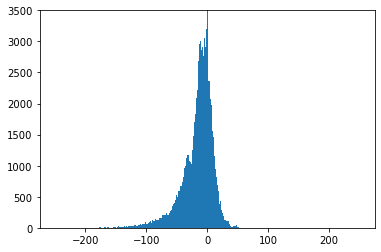

In [59]:
plt.hist(Q_sens_merged, np.arange(-250, 250, 0.5))
#plt.hist(Q_lat_merged, np.arange(-250, 250, 0.5))
plt.ylim(0,3500)

plt.show()

In [80]:
plt.hist(dist_cov_merged, np.arange(0, 0.3, 0.005))
plt.xlim(0, 0.3)
plt.axvline( np.nanmean(dist_cov_merged), color='k', linestyle='dashed', linewidth=1, label='mean ='+str(np.round(np.nanmean(dist_cov_merged),2))+'  km')
plt.xlabel('distance between measurments [km]')
plt.legend()
#plt.savefig("Apr21_Sd_all_distance_between_meas.png", bbox_inches='tight', transparent=True)
plt.show()


NameError: name 'dist_cov_merged' is not defined

In [11]:
# mask the complete row if one sensore is nan 
for d in df: 
    mask= np.ones(df[d].shape[0])
    for i in df[d].columns:
        mask= np.zeros(df[d].shape[0])*df[d][i]+mask

    for i in df[d].columns:
        df[d][i]=df[d][i]*mask

# A Heat flux changes changing resolution

## 1.3 Looking closer at spikes in density gradient

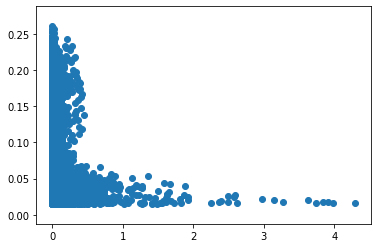

In [12]:
plt.scatter(df['1023']['density_grad'],df['1023']['dist_cov'])

In [23]:
l= np.where(df['1023']['density_grad'] == np.max(df['1023']['density_grad']))[0][0]
(df['1023']['dist_cov'])[l]

0.016454389663823597

C:\Users\Hanna\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


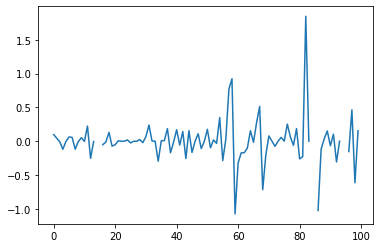

In [27]:
plt.plot(np.diff(df['1023']['R'])[l-50:l+50])

# 2. Find SST fronts

In [22]:
# this code could be improved further with pd, but it works for now
#'1020'
dens_threshold = 0.010
front_grad= 0#0.007#0.0015
density_grad = df['1020']['density_grad']
time =  df['1020'].index
Q= df['1020']['Q_sens']
T_air_diff= np.diff(df['1020']['airtemp'])
sal= df['1020']['salinity']
wind_diff= np.diff(df['1020']['wind'])
distance_from_NZ = df['1020']['dist_NZ']
sst=  df['1020']['sst']
R_roll5= df['1020']['R']


f_sensQ_1020 = SD.find_fronts_grad_test(density_grad, time, Q, T_air_diff,
                           sal, wind_diff, dens_threshold, front_grad, 0.04, 0.4, 
                           distance_from_NZ, 0, sst, R_roll5, 0.015, True, True, 5)



In [23]:
Q= df['1020']['Q_lat']
f_latQ_1020 = SD.find_fronts_grad_test(density_grad, time, Q, T_air_diff,
                           sal, wind_diff, dens_threshold, front_grad, 0.04, 0.4, 
                           distance_from_NZ, 0, sst, R_roll5, 0.015, True, True, 5)

In [24]:

#'1022'
density_grad = df['1022']['density_grad']
time =  df['1022'].index
Q= df['1022']['Q_sens']
T_air_diff= np.diff(df['1022']['airtemp'])
sal= df['1022']['salinity']
wind_diff= np.diff(df['1022']['wind'])
distance_from_NZ = df['1022']['dist_NZ']
sst=  df['1022']['sst']
R_roll5= df['1022']['R']

f_sensQ_1022 = SD.find_fronts_grad_test(density_grad, time, Q, T_air_diff,
                           sal, wind_diff, dens_threshold, front_grad, 0.04, 0.4, 
                           distance_from_NZ, 0, sst, R_roll5, 0.015, True, True, 5)
Q= df['1022']['Q_lat']
f_latQ_1022 = SD.find_fronts_grad_test(density_grad, time, Q, T_air_diff,
                           sal, wind_diff, dens_threshold, front_grad, 0.04, 0.4, 
                           distance_from_NZ, 0, sst, R_roll5, 0.015, True, True, 5)

#'1023'
density_grad = df['1023']['density_grad']
time =  df['1023'].index
Q= df['1023']['Q_sens']
T_air_diff= np.diff(df['1023']['airtemp'])
sal= df['1023']['salinity']
wind_diff= np.diff(df['1023']['wind'])
distance_from_NZ = df['1023']['dist_NZ']
sst=  df['1023']['sst']
R_roll5= df['1023']['R']

f_sensQ_1023 = SD.find_fronts_grad_test(density_grad, time, Q, T_air_diff,
                           sal, wind_diff, dens_threshold, front_grad, 0.04, 0.4, 
                           distance_from_NZ, 0, sst, R_roll5, 0.015, True, True, 5)
Q= df['1023']['Q_lat']
f_latQ_1023 = SD.find_fronts_grad_test(density_grad, time, Q, T_air_diff,
                           sal, wind_diff, dens_threshold, front_grad, 0.04, 0.4, 
                           distance_from_NZ, 0, sst, R_roll5, 0.015, True, True, 5)

In [23]:
def find_background1(x, t, heatflux, T_air_diff, sal, w_diff, frontsize_mean, front_grad, temp_max, wind_max, distance, toleranz, t_ctd, R, min_dist, temp_front= False, min_length=False, min_points=4): 
    import numpy as np
    '''
    find_fronts_grad(x, t, heatflux, T_air, sal, w,  frontsize_mean, front_grad, temp_max, wind_max, distance, t_ctd)
    x: density gradient [kg/m^3*1/km]
    t: time 
    heatflux: Heatflux [W/m^2]
    T_air: air temperature [°C]
    sal: salinity [PSU]
    w: wind speed [m/s]
    frontsize_mean: minimal front size for detection
    front_grad: minimal front gradient for detection
    temp_max: max air temp gradient for detection
    wind_max: max wind speed grad for front detection
    distance: commulative distance from start [km]
    R: absolute density ratio
    Temp_front: True or False 
    min_dist: minimum distance of two consecutive points to detect front start [km]
    min_length: minimum lenght of front is 5 data points
    
    output: 0: start
            1: stop 
            2: front_index
            3: front size/length
            4: front magnitude
            5: Q_change over front
               6: sal change over front 
            7: t_ctd change over front
            8: abs Q_change over front
    '''
    start=[]
    stop=[]
    b_indx=[]
    b_Qgrad=[]
    b_data =[]
    
    def condition(x, k, T_air_diff, w_diff, frontsize_mean, front_grad, temp_max, wind_max, distance, min_dist):
        if np.isnan(x[k]):
            return False
        elif temp_front==False:
            if  x[k] < frontsize_mean and np.abs(T_air_diff[k]) < temp_max and np.abs(w_diff[k]) < wind_max and (distance[k+1]-distance[k])>=min_dist:
                return True 
            else:
                return False
        else:
            if  x[k] < frontsize_mean and np.abs(T_air_diff[k]) < temp_max and np.abs(w_diff[k]) < wind_max and R[k]<1 and (distance[k+1]-distance[k])>=min_dist:
                return True 
            else:
                return False
    k=0                
    while k < len(x)-2: 
        if condition(x, k, T_air_diff, w_diff, frontsize_mean, front_grad, temp_max, wind_max, distance, min_dist):
            true_points=[]
            true_points.append(k)
            
            f=1
            g=0
            b=True
            while b and k+f < len(x)-1:
                if (distance[k+f]-distance[k+g])<min_dist: 
                    f=f+1
                elif x[k+f] < frontsize_mean and np.abs(T_air_diff[k+f]) < temp_max and np.abs(w_diff[k+f]) < wind_max:#x[k+f]> x[k]+(x[k]*toleranz):
                    g=f
                    true_points.append(k+g)
                    f=f+1
                else:
                    b=False
                    #f=f-1
            
            if min_length: 
                if len(true_points)>=min_points:
                    start.append(k)
                    for i in range(g+1):
                        b_indx.append(k+i)
                    stop.append(k+g)
                    
                    q_back=[]
                    d_back=[]
                    for i in true_points:
                        q_back.append(heatflux[i])
                        d_back.append(distance[i])
                    if q_back:
                        #b_Qgrad.append(np.nanmean(np.abs(np.diff(q_back)))/(np.nanmean(np.diff(d_back))))
                        #b_Qgrad.append(np.nanmean(np.abs(np.diff(q_back))/np.diff(d_back)))
                        #b_Qgrad.append(np.nanmean(np.abs(np.diff(q_back)))/(d_back[-1]-d_back[0]))
                        b_Qgrad.append(np.nanstd(q_back)/(d_back[-1]-d_back[0])) # standard deviation devided by front legth. 
                        b_data.append([q_back,d_back])    
            else: 
                start.append(k)
                for i in range(g):
                    b_indx.append(k+i)
                stop.append(k+g)
            
            
            k=k+f
        else: 
            k=k+1
    return start, stop, b_indx, b_Qgrad, b_data

In [24]:
#background heat flux gradient: modified front finding function 
# Standing question: What is background noise: ongoing discussion
d1= '1023'
dens_threshold = 0.010
front_grad= 0#0.007#0.0015
density_grad = df[d1]['density_grad']
time =  df[d1].index
Q= df[d1]['Q_lat']
T_air_diff= np.diff(df[d1]['airtemp'])
sal= df[d1]['salinity']
wind_diff= np.diff(df[d1]['wind'])
distance_from_NZ = df[d1]['dist_NZ']
sst=  df[d1]['sst']
R_roll5= df[d1]['R']


b_sensQ_1020 = find_background1(density_grad, time, Q, T_air_diff,
                           sal, wind_diff, dens_threshold, front_grad, 0.04, 0.4, 
                           distance_from_NZ, 0, sst, R_roll5, 0.015, True, True, 5)

In [25]:
np.nanmean(b_sensQ_1020[3])

1.2453664844887573

In [26]:
#Background: std/ mean(front length)
#Qsens SD1020: 0.51
#Qlat  SD1020: 0.22

#Qsens SD1022: 0.71
#Qlat  SD1022: 1.29

#Qsens SD1023: 0.696
#Qlat  SD1023: 1.25
Q_bg=[0.51, 0.22, 0.71, 1.29, 0.7, 1.25]
np.mean(Q_bg)

0.7799999999999999

In [67]:
### Background DQ/DX change 
# step 1: find non-frontal areas 
# test first for SD1020 
distance_from_NZ = df['1020']['dist_NZ']

f_sensQ_1020[2]

d_back=[]
background_id = []
background_q = []
q_back = []
for i in range(len(df['1020']['Q_sens'])):
    b = False
    if (i not in f_sensQ_1020[2] and i>f_sensQ_1020[0][0]):
        background_id.append(i)
        b = True
    if b:
        q_back.append(df['1020']['Q_sens'][i])
        d_back.append(distance_from_NZ[i])
    elif q_back:
        background_q.append(np.nanmean(np.abs(np.diff(q_back))/np.diff(d_back)))
        
        q_back = []
        d_back=[]

<ipython-input-67-21f89702b77e>:21: RuntimeWarning: Mean of empty slice
  background_q.append(np.nanmean(np.abs(np.diff(q_back))/np.diff(d_back)))


In [46]:
l=[2]
k=[4]
np.nanmean(np.abs(np.diff(l))/np.diff(k))

<ipython-input-46-a8cc0730fa84>:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.abs(np.diff(l))/np.diff(k))


nan

<ipython-input-70-424bb262404a>:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1b.set_xticklabels(dist_labels)


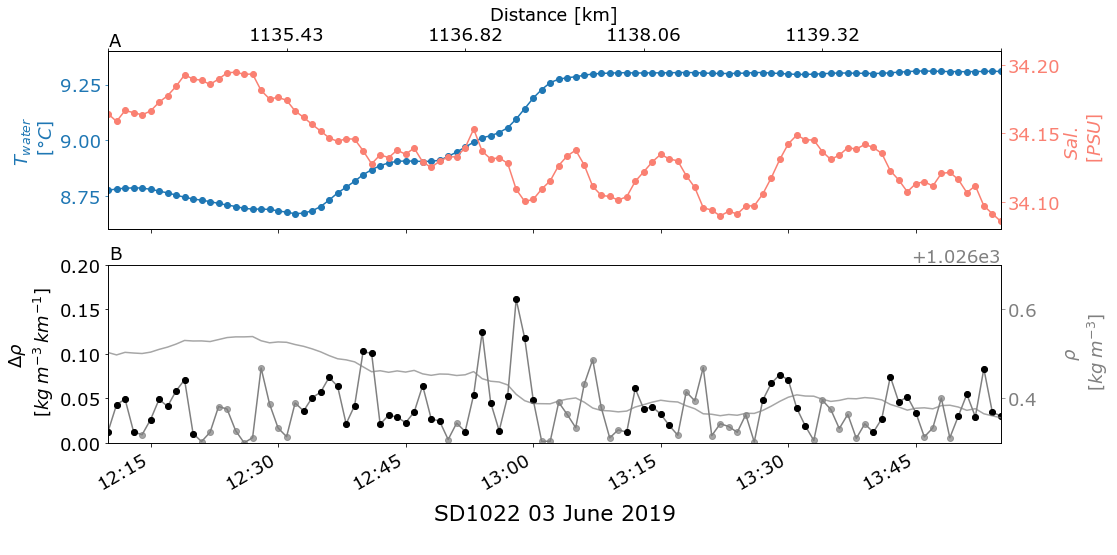

In [70]:
from matplotlib import dates
from matplotlib import rc 
#font = {'family':'serif', 'serif': ['computer modern roman']}
#plt.rc('font',**font)
#plt.rc('text', usetex=True)
fig = plt.figure(figsize=[16, 8])
font = {'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
#pick_time=datetime.datetime(2019, 6, 3, 11, 30, 0), datetime.datetime(2019, 6, 3, 14, 0, 5)
pick_time=datetime.datetime(2019, 6, 3, 12, 10, 0), datetime.datetime(2019, 6, 3, 13, 55, 0)

d ='1022'
x= df[d]['density_grad']#'densdensity_grad_5roll
t= df[d].index#np.array(time_5roll.time[2:-2])
zeros= np.zeros(len(x))

y5= df[d]['sst']#temp_ctd_5roll[2:-2]
y6= df[d]['salinity']#sal_5roll[2:-2]
y7= df[d]['density_grad']#density_grad_5roll[2:-2]
y8= df[d]['density']#esnity_5roll[2:-2]

width = [1, 1]
spec = fig.add_gridspec(ncols=6, nrows=2, height_ratios= width)

ax1 = fig.add_subplot(spec[1,:])
ax2 = fig.add_subplot(spec[0,:])

ax1.set_xlim(pick_time)
ax2.set_xlim(pick_time)

ax1a = ax1.twinx()
ax2a = ax2.twinx()



ax2.plot(t, y5)
ax2.scatter(t, y5)
ax2.tick_params(axis='y', colors='C0')
ax2a.plot(t, y6, color= 'salmon')
ax2a.scatter(t, y6, color= 'salmon')
ax2a.tick_params(axis='y', colors='salmon')
ax2.set_ylim(8.6, 9.4) # 0.8



ax2.set_title('SD1022 03 June 2019\n',y=-1.8)
ax1.set_ylabel('$\Delta \\rho$ \n $[kg\:m^{-3}\:km^{-1}]$', color='k')
ax1a.plot(t, y8, color= 'grey', zorder=0, alpha=0.7)
ax1a.tick_params(axis='y', colors='grey')


ax2a.set_xlabel('Distance [km]')

ax1.plot(t, y7, color= 'grey', zorder=0)
ax1.scatter(t, y7, c= 'grey', alpha= 0.7, zorder=0)

ax1.scatter(t[f_sensQ_1022[2]], y7[f_sensQ_1022[2]], c= 'k', zorder=2)
ax1.tick_params(axis='y', colors='k')
ax1.set_ylim(0, 0.2)

################

ax2a.set_ylabel('$Sal.$ \n $[PSU]$', color='salmon')
ax2.set_ylabel('$T_{water}$ \n $[°C]$', color='C0')
ax1a.set_ylabel('$\\rho $ \n $[kg\:m^{-3}]$', color='grey')

ax2.tick_params(axis='x', which='both',  bottom=True, top=False, labelbottom=False)

axes= [ax1, ax2]

fig.align_ylabels()
fmtr = dates.DateFormatter("%H:%M")
ax = plt.gca()
ax1.xaxis.set_major_formatter(fmtr)
fig.autofmt_xdate()

ax1b = ax2a.twiny()

ax2a.set_ylim(34.08, 34.21) # 0.13
dist_labels = [str(d) for d in np.round(df[d]['dist_NZ'][9999:10050][::10],2)]
dist_labels[0]=''
dist_labels[-1]=''

lab=['B', 'A']

r = [2]
for i in range(2): 
    axes[i].annotate(lab[i],xy=[0.001, 1.03], xycoords='axes fraction', color='k')
    
ax1b.set_xticklabels(dist_labels)
ax2.set_xlabel('Distance [km]\n', labelpad= 10)
#ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')

#fig.autofmt_xdate()
ax1a.set_ylim(1026.3, 1026.7)
#ax1a.set_xlim(pick_time)
#plt.subplots_adjust(wspace=.8)
#fig.savefig("SD1022_casestudy_structure_front_addeddist_switched.png", bbox_inches='tight', transparent=True)
#fig.savefig("Rosenthal_etal_2022_figs/Fig8.pdf", bbox_inches='tight', transparent=True)

In [25]:
len(f_sensQ_1023[0])+len(f_sensQ_1020[0])+len(f_sensQ_1022[0])

4935

In [ ]:
## Get example for front finding function

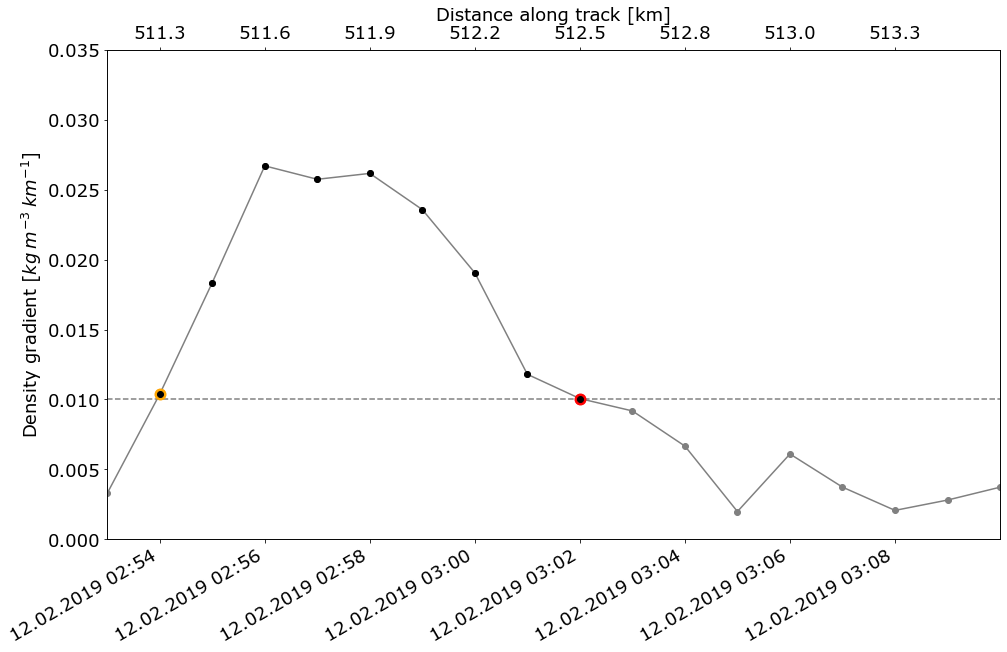

In [73]:
d= '1020'
time_frontparts= df['1020'].index[f_sensQ_1020[2]]
time_start_front= df['1020'].index[f_sensQ_1020[0]]
time_stop_front= df['1020'].index[f_sensQ_1020[1]]

from matplotlib import dates


    
l= 2000
k= 10
fig, (ax1) = plt.subplots(1,1,figsize =[16,10], sharex = True)

#pick_time = datetime.datetime(2019, 3, 1, 5, 0, 0), datetime.datetime(2019, 3, 1, 5, 50, 0)
pick_time = datetime.datetime(2019, 2, 12, 2, 53, 0), datetime.datetime(2019, 2, 12, 3, 10, 0)
pick_time_labels = [datetime.datetime(2019, 2, 12, 2, i, 0) for i in [54, 56, 58]]+[datetime.datetime(2019, 2, 12, 3, i, 0) for i in [0, 2, 4, 6 ,8]]
pick_dist= (df[d]['dist_NZ'][pick_time[0]], df[d]['dist_NZ'][pick_time[1]])
pick_index_start= np.where(df['1020'].index == pick_time[0])[0][0]
pick_index_start= np.where(df['1020'].index == pick_time[1])[0][0]
#plt.scatter(df[d].index,df[d]['density_grad'])
ax1.plot(df[d]['density_grad'], 'grey', zorder=0)
ax1.axhline(0.01, color='grey', linestyle='--', zorder=0)

ax1.scatter(df['1020'].index, df[d]['density_grad'], color= 'grey', zorder=0)
ax1.scatter(time_start_front, df[d]['density_grad'][f_sensQ_1020[0]], color= 'orange', s= 120,  zorder=1)
ax1.scatter(time_stop_front, df[d]['density_grad'][f_sensQ_1020[1]], color= 'red', s= 120,  zorder=1)
ax1.scatter(time_frontparts, df[d]['density_grad'][f_sensQ_1020[2]], color= 'black', zorder=2)

fig.autofmt_xdate()
fmtr = dates.DateFormatter("%d.%m.%Y %H:%M")
fmtr2= dates.DateFormatter("%Y-%m-%d %H:%M:%S")
plt.gca().xaxis.set_major_formatter(fmtr)

ax1.set_xlim(pick_time)
ax1.set_ylabel('Density gradient [$kg\:m^{-3}\:km^{-1}$]')
ax1.set_ylim(0,0.035)
ax1.set_xticks(pick_time_labels)

ticks_top = []
for i in pick_time_labels:
    ticks_top.append(np.round(df[d]['dist_NZ'][i], 1))

ax2 = ax1.twiny()
ax2.plot( df[d]['dist_NZ'], linewidth=0)
ax2.set_xlim(pick_time)
plt.gca().xaxis.set_major_formatter(fmtr2)
ax2.set_xticks(pick_time_labels)
ax2.set_xticklabels(ticks_top)
ax2.set_xlabel('Distance along track [km]')

#fig.savefig("Rosenthal_etal_2022_figs/Fig2.pdf", bbox_inches='tight', transparent=True)


In [26]:
len(f_sensQ_1023[8]+f_sensQ_1020[8]+f_sensQ_1022[8])

4935

In [27]:
sens_q_change_merged= np.concatenate((f_sensQ_1020[8], f_sensQ_1022[8], f_sensQ_1023[8]))
sens_q_change_non_abs_merged= np.concatenate((f_sensQ_1020[5], f_sensQ_1022[5], f_sensQ_1023[5]))

lat_q_change_merged = np.concatenate((f_latQ_1022[8], f_latQ_1023[8]))
lat_q_change_nonabs_merged = np.concatenate((f_latQ_1022[5], f_latQ_1023[5]))

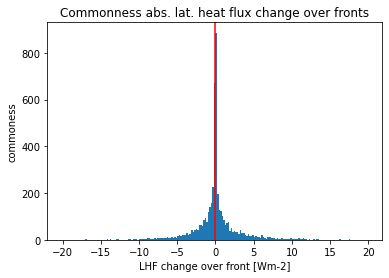

In [51]:
bins= np.arange(-20, 20, 0.2)
plt.hist(lat_q_change_nonabs_merged, bins)
plt.xlabel('LHF change over front [Wm-2]')
plt.ylabel('commoness')
plt.title('Commonness abs. lat. heat flux change over fronts')
plt.axvline(x=0, c='r')

#plt.savefig("Qchange_lat_overfronts.png", bbox_inches='tight', transparent=True)


In [28]:
# summarize 
sens_q_change_merged= np.concatenate((f_sensQ_1020[8], f_sensQ_1022[8], f_sensQ_1023[8])) # add SD 1020 
lat_q_change_merged = np.concatenate((f_latQ_1022[8], f_latQ_1023[8]))

#q_change_nonabs_merged= np.concatenate((q_change_nonabs_22, q_change_nonabs_23, q_change_nonabs_20))
#lat_q_nonabs_merged = np.concatenate((lat_q_change_nonabs_22, lat_q_change_nonabs_23))

fl_merged = np.concatenate((f_sensQ_1020[3], f_sensQ_1022[3], f_sensQ_1023[3]))
fl_merged_lat = np.concatenate((f_sensQ_1022[3], f_sensQ_1023[3]))
##
sst_changes_merged= np.concatenate((f_sensQ_1020[7], f_sensQ_1022[7], f_sensQ_1023[7]))
sal_changes_merged= np.concatenate((f_sensQ_1020[6], f_sensQ_1022[6], f_sensQ_1023[6]))
#rh_changes_merged= np.concatenate((rh_change_22, rh_change_23))
#airtemp_changes_merged= np.concatenate((f_sensQ_1020[6], f_sensQ_1022[6], f_sensQ_1023[6]))
#wind_changes_merged= np.concatenate((wind_change_20, wind_change_22, wind_change_23))


density_grad_5roll_22_23= np.concatenate((df['1022']['density_grad'],df['1023']['density_grad']))
density_grad_merged= np.concatenate((df['1020']['density_grad'], df['1022']['density_grad'], df['1023']['density_grad']))

In [76]:
#data=df['1020']['Q_sens'].values
data= df['1023']['Q_lat'].values
np.nanpercentile(abs(np.diff(data)),70)


0.9449397063258999

In [77]:
###### np.mean([0.35,0.69,0.82])# 75th percentile 
#np.mean([0.67,0.56,0.29])# mean of 70th percentile of sens ! changes in the dataset
np.mean([0.024,0.68,0.80])

0.5013333333333333

In [55]:
np.nanmedian(density_grad_merged)

0.008618242025125563

In [44]:
# need statistics here to find new thresholds for density gradient: 

In [15]:
np.nanmedian(np.abs(np.diff(density_grad_merged)))

0.0066143309512305265

In [50]:
np.nanpercentile(np.abs(np.diff(density_grad_merged)), 50)

0.0066143309512305265

In [51]:
np.nanpercentile(np.abs(density_grad_merged), 50)

0.010124614689223025

In [29]:
# new bin claculation for sens and lat heat (RUN THIS BEFORE BOXPLOT)
b1_fl= np.round(np.arange(0, 4.5, 0.5), 2)
fl= np.array(fl_merged)
sens_q_change= np.array(sens_q_change_merged)#np.array(q_change_nonabs_merged)#np.array(q_change_merged) #non-abs heat flux change: find[5] # abs heat flux change: find[8]
rel_q_change= np.array(sens_q_change)/np.array(fl)#np.array(find[8])#

fl_lat = np.array(fl_merged_lat)
lat_q_change = np.array(lat_q_change_merged)
rel_lat_q_change= np.array(lat_q_change)/np.array(fl_merged_lat)

indx_fl= {}
q_sum= {}
q_fl_mean= {}
q_fl_median={}
q_fl_std= {}
rel_q_fl_mean={}
q_change_frontsize= {}
rel_q_change_frontsize= {}

lat_indx_fl= {}
lat_q_sum= {}
lat_q_fl_mean= {}
lat_q_fl_median={}
lat_q_fl_std= {}
rel_lat_q_fl_mean={}
lat_q_change_frontsize= {}
rel_lat_q_change_frontsize={}

#q_change_frontsize_rel={}


for i in range(0, len(b1_fl)):
    if i == len(b1_fl)-1:
        indx_fl[str(b1_fl[i])]= np.where((fl> b1_fl[i]))
        lat_indx_fl[str(b1_fl[i])]= np.where((fl_lat> b1_fl[i]))
        #q_sum[str(b1_fl[i])]=sum(q_change[indx_fl[str(b1_fl[i])]])
    else:
        indx_fl[str(b1_fl[i])]= np.where((fl> b1_fl[i]) & (fl<b1_fl[i+1]))
        lat_indx_fl[str(b1_fl[i])]= np.where((fl_lat> b1_fl[i]) & (fl_lat<b1_fl[i+1]))
        
    q_fl_mean[str(b1_fl[i])]=np.mean(sens_q_change[indx_fl[str(b1_fl[i])]])
    q_fl_median[str(b1_fl[i])]=np.median(rel_q_change[indx_fl[str(b1_fl[i])]])
    rel_q_fl_mean[str(b1_fl[i])]=np.mean(rel_q_change[indx_fl[str(b1_fl[i])]])
    q_change_frontsize[str(b1_fl[i])]=sens_q_change[indx_fl[str(b1_fl[i])]]
    rel_q_change_frontsize[str(b1_fl[i])]=rel_q_change[indx_fl[str(b1_fl[i])]]
    q_fl_std[str(b1_fl[i])]=np.std(rel_q_change[indx_fl[str(b1_fl[i])]])
    q_sum[str(b1_fl[i])]=sum(sens_q_change[indx_fl[str(b1_fl[i])]])
    
    lat_q_fl_mean[str(b1_fl[i])]=np.mean(lat_q_change[lat_indx_fl[str(b1_fl[i])]])
    lat_q_fl_median[str(b1_fl[i])]=np.median(rel_lat_q_change[lat_indx_fl[str(b1_fl[i])]])
    rel_lat_q_fl_mean[str(b1_fl[i])]=np.mean(rel_lat_q_change[lat_indx_fl[str(b1_fl[i])]])
    lat_q_change_frontsize[str(b1_fl[i])]=lat_q_change[lat_indx_fl[str(b1_fl[i])]]
    rel_lat_q_change_frontsize[str(b1_fl[i])]=rel_lat_q_change[lat_indx_fl[str(b1_fl[i])]]
    lat_q_fl_std[str(b1_fl[i])]=np.std(rel_lat_q_change[lat_indx_fl[str(b1_fl[i])]])
    lat_q_sum[str(b1_fl[i])]=sum(lat_q_change[lat_indx_fl[str(b1_fl[i])]])
    


len_dir_fl= [len(indx_fl[i][0]) for i in indx_fl.keys()]
lat_len_dir_fl= [len(lat_indx_fl[i][0]) for i in lat_indx_fl.keys()]

In [27]:
np.nanpercentile(density_grad_merged, 99)

0.39304481828166143

In [25]:
np.nanmax(density_grad_merged)

4.298190195700736

In [57]:
bins= np.arange(0, 5, 0.01)
#plt.hist(density_grad_merged, bins)

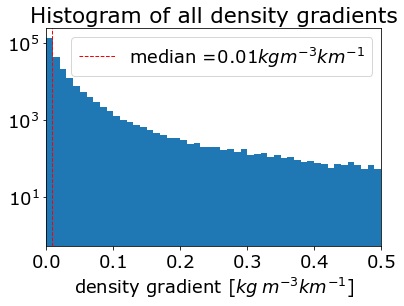

In [80]:
#density_grad_merged
bins= np.arange(0, 5, 0.01) # 14 km = 99% data 
plt.hist(density_grad_merged, bins)
plt.yscale('log')
#plt.xscale('log')

plt.xlabel('density gradient [$kg\:m^{-3} km^{-1}$]')
plt.title('Histogram of all density gradients')
plt.axvline(np.nanmedian(density_grad_merged), color='r', linestyle='dashed', linewidth=1, label='median ='+str(np.round(np.nanmedian(density_grad_merged),2))+'$kg m^{-3} km^{-1}$')
plt.legend()
plt.xlim(0, 0.5)
#plt.savefig("EGU_SDall_dens_grad_histogram_99th.png", bbox_inches='tight')
plt.show()

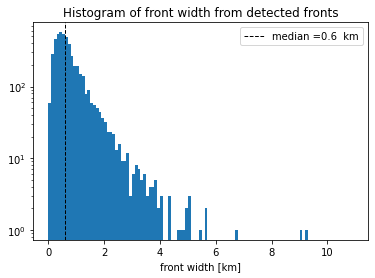

In [61]:
bins= np.arange(0, 11, 0.1) 
plt.hist(fl_merged, bins)
plt.yscale('log')
plt.xlabel('front width [km]')
plt.title('Histogram of front width from detected fronts')
plt.axvline(np.median(fl_merged), color='k', linestyle='dashed', linewidth=1, label='median ='+str(np.round(np.median(fl_merged),2))+'  km')
plt.legend()
#plt.savefig("EGU_SDall_frontlength_histogram.png", bbox_inches='tight')
plt.show()

In [69]:
np.max(fl_merged)

9.279273924294898

In [70]:
np.nanmax(fl_merged)

9.279273924294898

In [ ]:
np.percentile()

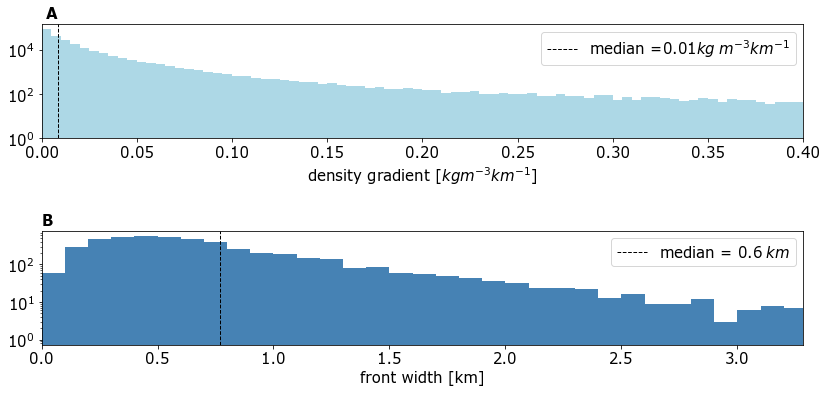

In [47]:
# combined dsens grad and front size detected 

bins= np.arange(0, 14, 0.1) # 14 km = 99% data 
fig, (ax1, ax2) = plt.subplots(2,1, figsize=[12,6])
per= 99

bins_dg= np.arange(0, 0.7, 0.005) # 14 km = 99% data 
ax1.hist(density_grad_merged, bins_dg, color='lightblue')
ax1.set_xlim(0, np.nanpercentile(density_grad_merged, per))
ax1.set_yscale('log')
ax1.set_xlabel('density gradient [$kg m^{-3} km^{-1}$]')
ax1.axvline(np.nanmedian(density_grad_merged), color='k', linestyle='dashed', linewidth=1, label='median ='+str(np.round(np.nanmedian(density_grad_merged),2))+'$kg\;m^{-3}km^{-1}$')
ax1.legend()
ax1.set_yticks([1, 100, 10000])

ax1.annotate('A',xy=[0.005, 1.05], xycoords='axes fraction', color='k', weight='bold')


ax2.hist(fl_merged, bins, color= 'steelblue')
ax2.set_xlim(0, np.nanpercentile(fl_merged, per))
ax2.set_xlabel('front width [km]')
ax2.axvline(np.mean(fl_merged), color='k', linestyle='dashed', linewidth=1, label='median = '+str(np.round(np.median(fl_merged),2))+'$\;km$')
ax2.set_yscale('log')
ax2.set_yticks([1, 10, 100])
ax2.legend()
ax2.annotate('B',xy=[0, 1.05], xycoords='axes fraction', color='k', weight='bold')

fig.tight_layout(pad=1.7)
#fig.savefig("Rosenthal_etal_2022_figs/FigS1.pdf", bbox_inches='tight')
#fig.show()


In [30]:
q_sum

{'0.0': 2194.319904658583,
 '0.5': 3044.390622333687,
 '1.0': 1359.594769125164,
 '1.5': 670.5226757857112,
 '2.0': 329.01218675481147,
 '2.5': 117.90352902133542,
 '3.0': 123.76239613067908,
 '3.5': 66.61132795664425,
 '4.0': 112.09312762631802}

Text(4.2, -0.35, '> 4')

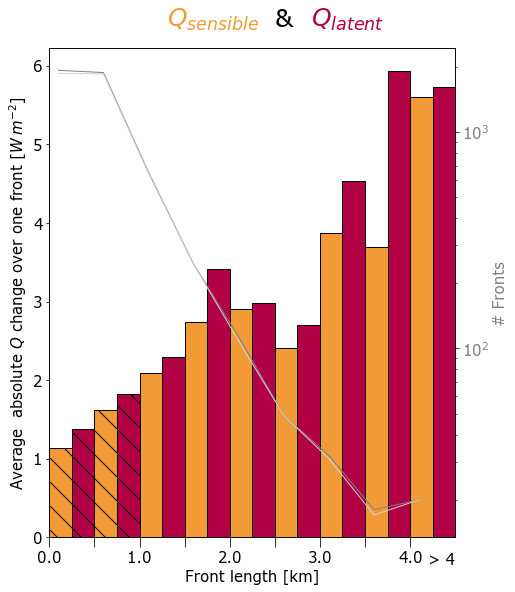

In [32]:
font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)


xx= list(np.round(b1_fl+0.1, 2))
limitx= 5.5
x_lat=b1_fl
labels=list(q_sum.keys())
labels_lat= list(lat_q_sum.keys())
k= len(len_dir_fl)
k_lat=  len(lat_len_dir_fl)
n = len_dir_fl
n_lat = lat_len_dir_fl
s =sum(list(q_sum.values()))/len(list(q_sum.values()))
s_lat= sum(list(lat_q_sum.values()))/len(list(lat_q_sum.values()))
end = 3
x223 = b1_fl
xshort= b1_fl[:-1]
col1='darkgrey'

#c= ['#004B89','#0076D6']
c= ["#f29b36","#b10043"] # red and orange 
#c = ['#31B05B', '#1F703A'] # shades of green

#c = ["#ff5c4e","#e30090"]
#c= ["#f29b36","#ff5c4e"]
#c = ["#7377ae","#6b9d97"]

s=sum(list(q_sum.values()))/len(list(q_sum.values()))
linex=[-1,0,2,3, 4, 5,6]
liney=[s,s,s,s, s, s,s]
liney_lat=[s_lat,s_lat,s_lat,s_lat,s_lat,s_lat, s_lat]


fig = plt.figure(figsize=[16,9])
#heights = [1, 2]
width = [2, 2]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios= width)
#ax2 = fig.add_subplot(spec[0])
#ax1a = fig.add_subplot(spec[1,0])
ax1 = fig.add_subplot(spec[1])
#ax2a = fig.add_subplot(spec[1,1])

#ax1.set_title('$Q_{sensible} &\, Q_{latent}$' )

ax1.set_xlabel('Front length [km]')
ax1.set_ylabel('Average  absolute $Q$ change over one front [$W\:m^{-2}$]')
ax1.tick_params(axis='y')
#ax1.plot(linex, liney,'--', color='lightgrey')

ax1a = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1a.set_ylabel('# Fronts', color='grey')  # we already handled the x-label with ax1

ax1a.plot(xx, n, color='grey',linewidth=1)
ax1a.plot(xx, n_lat, color='lightgrey',linewidth=1)

ax1a.tick_params(axis='y', labelcolor='grey')
ax1a.set_yscale('log')

#ax1a.tick_params(axis='y', labelcolor='grey')
#ax1a.set_yscale('log')
h = ['\\','\\','','', '','','','','','','']
for i in range(0, k):
    p= ax1.bar(b1_fl[i], q_sum[labels[i]]/n[i], 0.25, color=c[0], edgecolor='k', align = 'edge', hatch=h[i], zorder= 0)
    p= ax1.bar(x_lat[i]+0.25, lat_q_sum[labels_lat[i]]/n_lat[i], 0.25, color=c[1], edgecolor='k', align = 'edge', hatch=h[i], zorder= 1)
ax1.set_xticks(b1_fl)
ax1.set_xticklabels(labels)
ax1.set_xlim(0,4.5)
ax1.tick_params(axis="x", length=10)

#ax1.plot(linex, liney_lat, color=c[0])
#ax1.plot(linex, liney_lat,'--', color='darkgrey')
ax1a.set_yscale('log')
#ax1a.set_ylim(1,3000)
#ax1.set_ylim(0,3300)

#ax1a.tick_params(axis='y', labelcolor='orange')
ax1a.set_yscale('log')

    
#ax2.set_xticks(b1_fl)
#ax2.set_xticklabels(labels)
#ax2.set_xlim(0,limitx)
for label in ax1.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)



ax1.text(1.3, 6.5, "$Q_{sensible}$", weight='bold' , size=25,color=c[0])
ax1.text(2.6, 6.5, "&", ha="center", weight='normal' , size=25)
ax1.text(2.9, 6.5,"$Q_{latent}$", weight='bold' , size=25, color= c[1])
ax1.text(4.2, -.35, "> 4" , size=15)
#ax1.text(-.4, 679, '683',  size=13, color= c[1])
#ax1.text(-.4, 600, '613',  size=13, color= c[0])
#fig.tight_layout(pad=2.0)
#plt.xticks(np.arange(0, end, step=0.4))
#plt.xlim(0, end)
#plt.savefig("reversEGU_f_SDall_abs_Q_change_barplot_5km_transp_red.png", bbox_inches='tight', transparent=True)

In [33]:
q_sen=[]
q_lat=[]
for i in range(0,9):
    q_sen.append(q_sum[labels[i]]/n[i])
    q_lat.append(lat_q_sum[labels_lat[i]]/n_lat[i])

array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25])

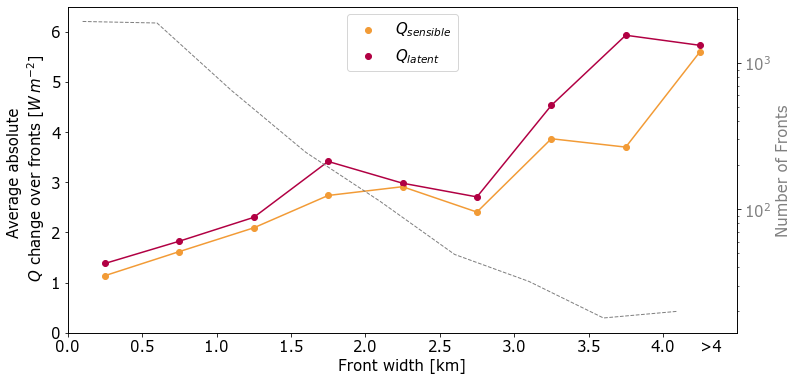

In [36]:
x_l= np.arange(0,4.5,.5)
x_l+0.25

c= ["#b10043","#f29b36"] # red and orange 
fig = plt.figure(figsize=[12,6])#14,8
#width = [2, 2]

ax1 = fig.add_subplot()
#ax1.xaxis.grid()
ax1.scatter(x_l+0.25,q_sen, color=c[1], label="$Q_{sensible}$")
ax1.plot(x_l+0.25,q_sen, color=c[1])

ax1.scatter(x_l+0.25,q_lat, color=c[0], label="$Q_{latent}$")
ax1.plot(x_l+0.25,q_lat, color=c[0])

ax1.set_ylabel('Average absolute \n $Q$ change over fronts [$W\:m^{-2}$]')
ax1.set_xticks(b1_fl)
ax1.set_ylim(0,6.5)
ax1.set_xlim(0,4.5)
ax1.set_xlabel('Front width [km]')
ax1.text(4.25, -.38, ">4" , size=15)

ax1a = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1a.set_ylabel('Number of Fronts', color='grey')  # we already handled the x-label with ax1
ax1a.tick_params(axis='y', labelcolor='grey')
ax1a.plot(xx, n,linestyle='dashed', color='grey',linewidth=1)

ax1a.set_yscale('log')
ax1.legend(loc='upper center')
threshold = 0.75
#ax1.axhline(threshold, color='green', lw=2, alpha=0.7)
#ax1.fill_between(x_l, 0, 1, where=y > threshold,
                #color='green', alpha=0.5, transform=ax.get_xaxis_transform())
    
#plt.savefig("Rosenthal_etal_2022_figs/Fig6_lineplot29722.pdf", bbox_inches='tight', transparent=True)

In [79]:
(q_sum['0.0']+q_sum['0.5'])/(sum(list(q_sum.values())))

0.6533515802877506

In [80]:
(lat_q_sum['0.0']+lat_q_sum['0.5'])/(sum(list(q_sum.values())))

0.7437652579143518

In [24]:
(q_sum_20['0.0']+q_sum_20['0.2']+q_sum_20['0.4']+q_sum_20['0.6']+q_sum_20['0.8'])/(sum(list(q_sum_20.values())))

NameError: name 'q_sum_20' is not defined

In [176]:
q_sum[str(b1_fl[0])]/len_dir_fl[0]

1.1387233547787146

In [39]:
percentile= 90
k=np.zeros(len(len_dir_fl))
for i in np.arange(11):
    k[i]= q_sum[str(b1_fl[i])]/len_dir_fl[i]
k

IndexError: index 9 is out of bounds for axis 0 with size 9

In [40]:
#data_lat =lat_q_change_frontsize

data_lat = [lat_q_change_frontsize[str(i)] for i in b1_fl]
#medians= 
upper_labels = [str(np.round(np.median(lat_q_change_frontsize[str(i)]),2)) for i in b1_fl]
#plt.boxplot(data_lat, positions=xx_lat, widths = 0.4, flierprops=red_cross, meanprops=black_tri, medianprops=red_line, whis=(5, 95),patch_artist=True)#, patch_artist = True)
#plt.show()
upper_labels

['0.42', '0.79', '1.07', '1.31', '1.6', '1.31', '1.81', '2.62', '3.22']

# stats about Q change over each individual front

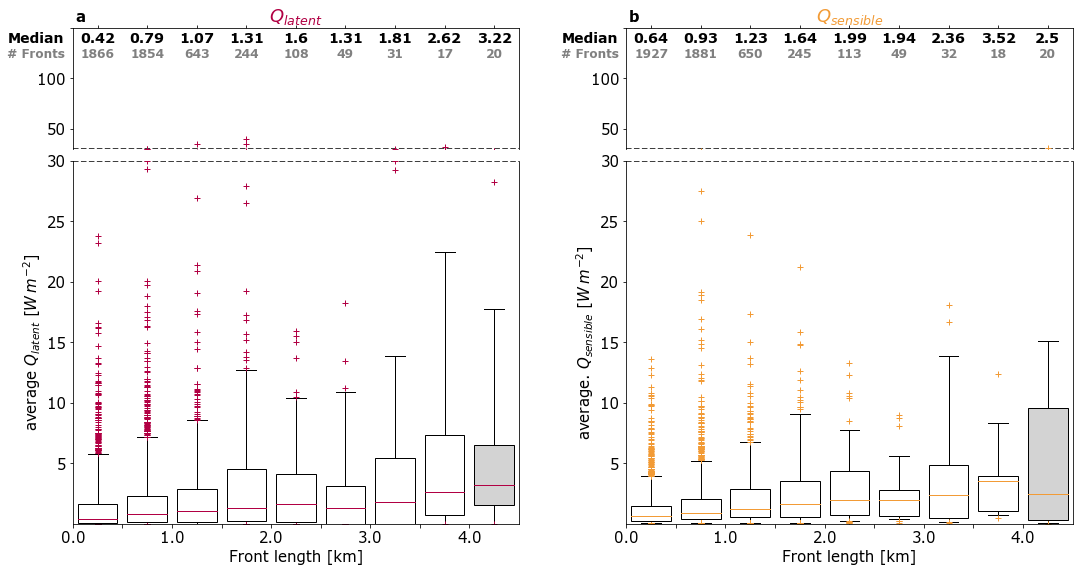

In [41]:
data = [q_change_frontsize[str(i)] for i in b1_fl]
data_lat = [lat_q_change_frontsize[str(i)] for i in b1_fl]
c= ["#b10043","#f29b36"] # red and orange 
xx= list(np.round(b1_fl+0.25, 2))
labels=list(q_sum.keys())
leng= len(labels)
breite = np.zeros(leng)
breite[:]=0.01
p=[]
for i in range(0, leng): 
    p.append(np.nanpercentile(rel_q_change_frontsize[labels[i]], 90))
xx_lat= list(np.round(b1_fl+0.25, 2))

labels_lat=list(lat_q_sum.keys())
leng_lat= len(labels_lat)
breite_lat = np.zeros(leng_lat)
breite_lat[:]=0.01
p_lat=[]
for i in range(0, leng): 
    p_lat.append(np.nanpercentile(rel_lat_q_change_frontsize[labels_lat[i]] , 90))
red_cross = dict(markeredgecolor=c[0], marker='+')
blue_cross = dict(markeredgecolor=c[1], marker='+')
black_tri= dict(markerfacecolor='k', markeredgecolor='k', marker="^")
red_line= dict(color=c[0])
blue_line= dict(color=c[1])

#### percentile computation
p= np.zeros(len(data))
p_lat= np.zeros(len(data))
#for i in range(len(data)):
    #p[i]= np.nanpercentile(data[i], 90)
    #p_lat[i]= np.nanpercentile(data_lat[i], 90)


fig = plt.figure(figsize=[16,9])

heights = [1, 3]
width = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, height_ratios=heights, width_ratios= width)
ax1 = fig.add_subplot(spec[0,0])
ax1a = fig.add_subplot(spec[1,0])
ax2 = fig.add_subplot(spec[0,1])
ax2a = fig.add_subplot(spec[1,1])

bplot1= ax1a.boxplot(data_lat, positions=xx_lat, widths = 0.4, flierprops=red_cross, meanprops=black_tri, medianprops=red_line, whis=(5, 95),patch_artist=True)#, patch_artist = True)
bplot2= ax1.boxplot(data_lat, positions=xx_lat, widths = 0.4, flierprops=red_cross, meanprops=black_tri , whis=(5, 95), patch_artist=True)#
bplot3=ax2a.boxplot(data,positions=xx, flierprops=blue_cross, widths = 0.4, meanprops=black_tri, medianprops=blue_line, whis=(5, 95), patch_artist=True)
bplot4= ax2.boxplot(data, positions=xx, flierprops=blue_cross, widths = 0.4, meanprops=black_tri, whis=(5, 95), patch_artist = True)

#ax2a.plot(xx, p, '--', c= 'grey')
#ax1a.plot(xx_lat, p_lat, '--',c=  'grey')
b ='white'
colors = []
for i in range(len(data_lat)):
    colors.append(b)
colors[-1]= 'lightgrey'
#colors = ['white', 'white', 'white', 'white','white','white','white','white','white','white','white','white','white','white','lightgrey']
for bplot in (bplot1, bplot2, bplot3, bplot4):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
limity= 30 
axes_a = [ax1a, ax2a]
for a in axes_a: 
    #a.set_ylim(0, limity)
    a.set_ylim(0.001, limity)
    a.set_xlim(0 ,4.5)
    a.set_xlabel('Front length [km]')
    a.spines['top'].set_visible(False)
    a.xaxis.tick_bottom()
    a.set_xticks(b1_fl)
    a.set_xticklabels(labels_lat)
    a.hlines(limity, 0, 6,linestyle='--', color='k')
    #a.set_yscale('log')
axes = [ax1, ax2]
for a in axes: 
    a.set_xlim(0, 4.5)
    a.set_ylim(limity, 150)
    a.spines['bottom'].set_visible(False)
    a.hlines(limity, 0, 6,linestyle='--', color='k')
    for label in a.yaxis.get_ticklabels()[-1:]:
        label.set_visible(False)
    
medians = list(q_fl_median.values())
medians_lat = list(lat_q_fl_median.values())
weights = 'semibold'
num_boxes = len(data)
num_boxes_lat = len(data_lat)
medians = list(q_fl_median.values())

ax1a.text(-.37, .88,'Median', transform=ax1.get_xaxis_transform(),
         horizontalalignment='center', size=14, weight=weights)
ax1a.text(-.37, .75,'# Fronts',color='grey', transform=ax1.get_xaxis_transform(),
         horizontalalignment='center', size=12, weight=weights)
#upper_labels_lat = [str(np.round(s_lat, 1)) for s_lat in medians_lat]
upper_labels_lat = [str(np.round(np.median(lat_q_change_frontsize[str(i)]),2)) for i in b1_fl]
lower_lab_lat= lat_len_dir_fl
weights = 'semibold'
pos_lat = xx_lat
for tick, label in zip(range(num_boxes_lat), ax1a.get_xticklabels()):
    k_lat = tick % 2
    ax1a.text(pos_lat[tick], .88, upper_labels_lat[tick],
             transform=ax1.get_xaxis_transform(), horizontalalignment='center', size=10,
             weight=weights, fontsize = 14)
    
    ax1a.text(pos_lat[tick], .75, lower_lab_lat[tick], color='grey',
             transform=ax1.get_xaxis_transform(), horizontalalignment='center', size=10,
             weight=weights, fontsize = 12)

## ax2
ax2a.text(-.37, .88,'Median', transform=ax2.get_xaxis_transform(),
         horizontalalignment='center', size=14, weight=weights)
ax2a.text(-.37, .75,'# Fronts',color='grey', transform=ax2.get_xaxis_transform(),
         horizontalalignment='center', size=12, weight=weights)
upper_labels = [str(np.round(np.median(q_change_frontsize[str(i)]),2)) for i in b1_fl]
lower_lab= len_dir_fl
weights = 'semibold'
pos = xx
for tick, label in zip(range(num_boxes), ax2a.get_xticklabels()):
    k = tick % 2
    ax2a.text(pos[tick], .88, upper_labels[tick],
             transform=ax2.get_xaxis_transform(), horizontalalignment='center', size=10,
             weight=weights, fontsize = 14)
    
    ax2a.text(pos[tick], .75, lower_lab[tick], color='grey',
             transform=ax2.get_xaxis_transform(), horizontalalignment='center', size=10,
             weight=weights, fontsize = 12)
    
ax1.set_title('$Q_{latent}$', color=c[0])
ax2.set_title('$Q_{sensible}$', color=c[1])
ax2a.set_ylabel('average. $Q_{sensible}$ [$W\:m^{-2}$]')
ax1a.set_ylabel('average $Q_{latent}$ [$W\:m^{-2}$]')

ax1.xaxis.tick_top()
ax1.tick_params(labeltop= False)  # don't put tick labels at the top

ax2.xaxis.tick_top()
ax2.tick_params(labeltop= False)  # don't put tick labels at the top
#ax2a.plot(xx_lat, p_lat , '--', color='dimgrey')
for label in ax1a.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
for label in ax2a.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
x = [xx, xx_lat]
lab=['a', 'b']


    
for i in range(2): 
    axes[i].annotate(lab[i],xy=[0.005, 1.05], xycoords='axes fraction', color='k', weight='bold')
 #   axes[i].plot(x[i], percentile[i], '--')
fig.tight_layout(pad=3.0)
fig.subplots_adjust(hspace=0.05) 


#for label in ax2a.xaxis.get_ticklabels()[::2]:
   # label.set_visible(False)
#plt.savefig("EGU_f_SDall_boxplot_average_fronts.png", bbox_inches='tight', transparent=True)
#plt.boxplot(data_lat, positions=xx_lat, widths = 0.12, flierprops=red_cross,meanprops=black_tri, medianprops=red_line, whis=(5, 95),patch_artist=True)
plt.show()


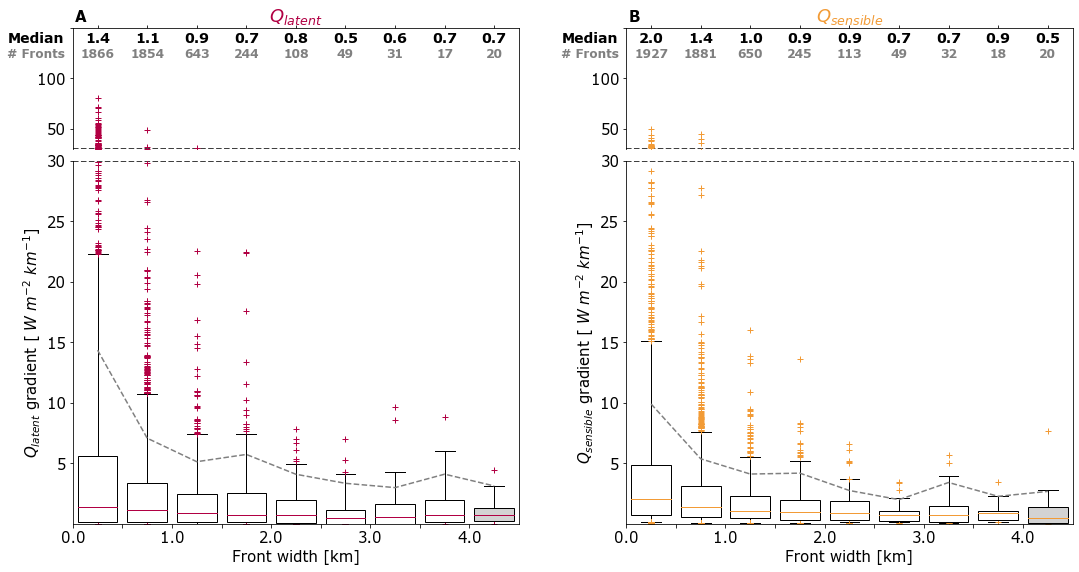

In [46]:
# divided by front number: 
data = [rel_q_change_frontsize[str(i)] for i in b1_fl]
data_lat = [rel_lat_q_change_frontsize[str(i)] for i in b1_fl]#] list(q_fl_std.values())
xx= list(np.round(b1_fl+0.25, 2))
labels=list(q_sum.keys())
leng= len(labels)
breite = np.zeros(leng)
breite[:]=0.01
p=[]
c= ["#b10043","#f29b36"] # red and orange 

for i in range(0, leng): 
    p.append(np.nanpercentile(rel_q_change_frontsize[labels[i]], 90))

data_lat = [rel_lat_q_change_frontsize[str(i)] for i in b1_fl]#] list(q_fl_std.values())
xx_lat= list(np.round(b1_fl+0.25, 2))

labels_lat=list(lat_q_sum.keys())
leng_lat= len(labels_lat)
breite_lat = np.zeros(leng_lat)
breite_lat[:]=0.01
p_lat=[]
for i in range(0, leng): 
    p_lat.append(np.nanpercentile(rel_lat_q_change_frontsize[labels_lat[i]] , 90))
red_cross = dict(markeredgecolor=c[0], marker='+')
blue_cross = dict(markeredgecolor=c[1], marker='+')
black_tri= dict(markerfacecolor='k', markeredgecolor='k', marker="^")
red_line= dict(color=c[0])
blue_line= dict(color=c[1])

#### percentile computation
p= np.zeros(len(data))
p_lat= np.zeros(len(data))
for i in range(len(data)):
    p[i]= np.nanpercentile(data[i], 90)
    p_lat[i]= np.nanpercentile(data_lat[i], 90)


fig = plt.figure(figsize=[16,9])

heights = [1, 3]
width = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, height_ratios=heights, width_ratios= width)
ax1 = fig.add_subplot(spec[0,0])
ax1a = fig.add_subplot(spec[1,0])
ax2 = fig.add_subplot(spec[0,1])
ax2a = fig.add_subplot(spec[1,1])

bplot1= ax1a.boxplot(data_lat, positions=xx_lat, widths = 0.4, flierprops=red_cross, meanprops=black_tri, medianprops=red_line, whis=(5, 95),patch_artist=True)#, patch_artist = True)
bplot2= ax1.boxplot(data_lat, positions=xx_lat, widths = 0.4, flierprops=red_cross, meanprops=black_tri , whis=(5, 95), patch_artist=True)#
bplot3=ax2a.boxplot(data,positions=xx, flierprops=blue_cross, widths = 0.4, meanprops=black_tri, medianprops=blue_line, whis=(5, 95), patch_artist=True)
bplot4= ax2.boxplot(data, positions=xx, flierprops=blue_cross, widths = 0.4, meanprops=black_tri, whis=(5, 95), patch_artist = True)

ax2a.plot(xx, p, '--', c= 'grey')
ax1a.plot(xx_lat, p_lat, '--',c=  'grey')
b ='white'
colors = []
for i in range(len(data_lat)):
    colors.append(b)
colors[-1]= 'lightgrey'
#colors = ['white', 'white', 'white', 'white','white','white','white','white','white','white','white','white','white','white','lightgrey']
for bplot in (bplot1, bplot2, bplot3, bplot4):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
limity= 30 
axes_a = [ax1a, ax2a]
for a in axes_a: 
    #a.set_ylim(0, limity)
    a.set_ylim(0.001, limity)
    a.set_xlim(0 ,4.5)
    a.set_xlabel('Front width [km]')#('Front length [km]')
    a.spines['top'].set_visible(False)
    a.xaxis.tick_bottom()
    a.set_xticks(b1_fl)
    a.set_xticklabels(labels_lat)
    a.hlines(limity, 0, 6,linestyle='--', color='k')
    #a.set_yscale('log')
axes = [ax1, ax2]
for a in axes: 
    a.set_xlim(0, 4.5)
    a.set_ylim(limity, 150)
    a.spines['bottom'].set_visible(False)
    a.hlines(limity, 0, 6,linestyle='--', color='k')
    for label in a.yaxis.get_ticklabels()[-1:]:
        label.set_visible(False)
    
medians = list(q_fl_median.values())
medians_lat = list(lat_q_fl_median.values())
weights = 'semibold'
num_boxes = len(data)
num_boxes_lat = len(data_lat)
medians = list(q_fl_median.values())

ax1a.text(-.37, .88,'Median', transform=ax1.get_xaxis_transform(),
         horizontalalignment='center', size=14, weight=weights)
ax1a.text(-.37, .75,'# Fronts',color='grey', transform=ax1.get_xaxis_transform(),
         horizontalalignment='center', size=12, weight=weights)
upper_labels_lat = [str(np.round(s_lat, 1)) for s_lat in medians_lat]
lower_lab_lat= lat_len_dir_fl
weights = 'semibold'
pos_lat = xx_lat
for tick, label in zip(range(num_boxes_lat), ax1a.get_xticklabels()):
    k_lat = tick % 2
    ax1a.text(pos_lat[tick], .88, upper_labels_lat[tick],
             transform=ax1.get_xaxis_transform(), horizontalalignment='center', size=10,
             weight=weights, fontsize = 14)
    
    ax1a.text(pos_lat[tick], .75, lower_lab_lat[tick], color='grey',
             transform=ax1.get_xaxis_transform(), horizontalalignment='center', size=10,
             weight=weights, fontsize = 12)

## ax2
ax2a.text(-.37, .88,'Median', transform=ax2.get_xaxis_transform(),
         horizontalalignment='center', size=14, weight=weights)
ax2a.text(-.37, .75,'# Fronts',color='grey', transform=ax2.get_xaxis_transform(),
         horizontalalignment='center', size=12, weight=weights)
upper_labels = [str(np.round(s, 1)) for s in medians]
lower_lab= len_dir_fl
weights = 'semibold'
pos = xx
for tick, label in zip(range(num_boxes), ax2a.get_xticklabels()):
    k = tick % 2
    ax2a.text(pos[tick], .88, upper_labels[tick],
             transform=ax2.get_xaxis_transform(), horizontalalignment='center', size=10,
             weight=weights, fontsize = 14)
    
    ax2a.text(pos[tick], .75, lower_lab[tick], color='grey',
             transform=ax2.get_xaxis_transform(), horizontalalignment='center', size=10,
             weight=weights, fontsize = 12)
    
ax1.set_title('$Q_{latent}$', color=c[0])
ax2.set_title('$Q_{sensible}$', color=c[1])
ax2a.set_ylabel('$Q_{sensible}$ gradient [$~W~m^{-2}~km^{-1}$]')
ax1a.set_ylabel('$Q_{latent}$ gradient [$~W~m^{-2}~km^{-1}$]')

ax1.xaxis.tick_top()
ax1.tick_params(labeltop= False)  # don't put tick labels at the top

ax2.xaxis.tick_top()
ax2.tick_params(labeltop= False)  # don't put tick labels at the top
#ax2a.plot(xx_lat, p_lat , '--', color='dimgrey')
for label in ax1a.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
for label in ax2a.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
x = [xx, xx_lat]
lab=['A', 'B']


    
for i in range(2): 
    axes[i].annotate(lab[i],xy=[0.005, 1.05], xycoords='axes fraction', color='k', weight='bold')
 #   axes[i].plot(x[i], percentile[i], '--')
fig.tight_layout(pad=3.0)
fig.subplots_adjust(hspace=0.05) 


#for label in ax2a.xaxis.get_ticklabels()[::2]:
   # label.set_visible(False)
#plt.savefig("Rosenthal_etal_2022_figs/Fig7_boxes.pdf", bbox_inches='tight', transparent=True, dpi=500)
#plt.boxplot(data_lat, positions=xx_lat, widths = 0.12, flierprops=red_cross,meanprops=black_tri, medianprops=red_line, whis=(5, 95),patch_artist=True)
plt.show()

####CHANGE HERE: yticks upper panel only 50 and 100 , delete others, so no overlapping with MEdian abel is visable 

In [54]:
len(data_lat[0])

1866

In [76]:
np.percentile(data[8], 90)

2.6776859903044667

In [ ]:
    df[d]['R'] = np.abs((gsw.alpha(gsw.SA_from_SP(df[d]['salinity'], sensor_p, df[d]['longitude'], df[d]['latitude']), 
                                   gsw.CT_from_t(df[d]['salinity'], df[d]['sst'], sensor_p), p)[:-1]*np.diff(df[d]['airtemp']))/
                        (gsw.beta(SA, gsw.CT_from_t(df[d]['salinity'], df[d]['sst'], sensor_p), p)[:-1]*np.diff(df[d]['salinity'])))

In [ ]:


SA=gsw.SA_from_SP(sal, p, long, lat)
CT= gsw.CT_from_t(sal, sst, p)
alpha=gsw.alpha(SA, CT, p)
beta= gsw.beta(SA, CT, p)


dist_covered_1min= sw.dist(lat,long, units='km')[0]
l=len(dist_covered_1min)
distance_from_NZ= np.zeros(l+1)

for i in range(1, l+1):
    if i==1:
        distance_from_NZ[i]=dist_covered_1min[0]
    else:
        distance_from_NZ[i]=distance_from_NZ[i-1]+dist_covered_1min[i-1]


R_roll5=np.abs((alpha[:-1]*np.diff(airtemp))/(beta[:-1]*np.diff(sal)))

delta_dens=np.abs(np.diff(density))
density_grad=(delta_dens)/(dist_covered_1min)

R_roll5=np.abs((alpha[:-1]*np.diff(airtemp))/(beta[:-1]*np.diff(sal)))